# BAB 1 - Perkenalan

Nama : Bagas

Batch : RMT-41

Problem Statement :
Meningkatkan kualitas deteksi dini pasien berisiko penyakit jantung dengan membangun sistem prediksi berbasis Machine Learning menggunakan data indikator kesehatan di Rumah Sakit XYZ. Sistem ini diharapkan mampu meminimalkan kasus pasien yang tidak terdiagnosis secara tepat, serta mendukung tenaga medis dalam pengambilan keputusan klinis yang lebih cepat dan akurat dalam kurun waktu tiga bulan ke depan.

Objektif :
Mengembangkan model klasifikasi untuk memprediksi penyakit jantung berdasarkan indikator kesehatan pasien di Rumah Sakit XYZ menggunakan lima algoritma yaitu KNN, SVM, Decision Tree, Random Forest, dan XGBoost. Setiap model dievaluasi untuk mendeteksi pasien yang benar-benar memiliki penyakit jantung, dengan fokus pada metrik recall guna meminimalkan false negative, yaitu kesalahan saat model memprediksi tidak ada penyakit jantung padahal sebenarnya ada, yang dapat berakibat fatal karena menunda penanganan medis. Dari kelima model, SVM dipilih sebagai model terbaik karena menunjukkan performa paling stabil bahkan dengan parameter default. Model ini kemudian dioptimasi melalui hyperparameter tuning dan penanganan class imbalance menggunakan SMOTENC. Evaluasi akhir dilakukan menggunakan cross-validation untuk memastikan performa dan stabilitas deteksi kasus positif secara konsisten.

# Conceptual Problems

## 1. Jelaskan latar belakang adanya bagging dan cara kerja bagging !

Bagging adalah singkatan dari Bootstrap Aggregating, yaitu metode ensemble learning yang dibuat untuk meningkatkan akurasi dan stabilitas model, khususnya pada model yang rentan terhadap overfitting seperti decision tree. Metode ini bekerja dengan mengambil sampel data secara acak dan berulang (bootstrapping), lalu melatih beberapa model secara terpisah pada subset data tersebut. Setelah semua model dilatih, hasil prediksinya digabungkan dan biasanya dengan voting untuk tugas klasifikasi atau rata-rata untuk regresi. Dengan menggabungkan beberapa model, hasil prediksi menjadi lebih konsisten dan tidak mudah terpengaruh oleh kesalahan dari satu model saja.

## 2. Jelaskan perbedaan cara kerja algoritma Random Forest dengan algoritma boosting yang Anda pilih !

Perbedaan utama antara algoritma Random Forest dan XGBoost terletak pada cara keduanya membangun dan menggabungkan model decision tree. Random Forest menggunakan pendekatan bagging, di mana banyak decision tree dilatih secara paralel pada subset data yang berbeda, lalu hasilnya digabungkan menggunakan voting (untuk klasifikasi) atau rata-rata (untuk regresi). Tujuannya adalah mengurangi variansi dan meningkatkan stabilitas model. 

Sementara itu, XGBoost menggunakan pendekatan boosting, di mana decision tree dibangun secara berurutan, dan setiap pohon baru bertugas memperbaiki kesalahan dari pohon sebelumnya. XGBoost juga menggunakan teknik optimasi seperti regularisasi dan pengurangan error berbasis gradient, yang membuatnya lebih akurat dan efisien. Jadi, jika Random Forest fokus pada mengurangi variansi, XGBoost lebih fokus pada mengurangi bias model.

## 3. Jelaskan apa yang dimaksud dengan Cross Validation !

Cross Validation adalah teknik dalam machine learning yang digunakan untuk memperkirakan performa model pada data yang belum pernah dilihat sebelumnya. Teknik ini bekerja dengan membagi data pelatihan menjadi beberapa bagian kecil yang disebut fold. Model kemudian dilatih pada kombinasi k–1 fold dan diuji pada fold yang tersisa, proses ini diulang sampai setiap fold pernah menjadi data validasi. Hasil evaluasi dari semua iterasi kemudian dirata-rata untuk menghasilkan nilai akurasi, MAE, MAPE, atau metrik lainnya, yang disebut sebagai cross-validation score. Selain nilai rata-rata, standar deviasi dari hasil evaluasi juga dihitung untuk mengetahui seberapa konsisten performa model. Dengan demikian, cross validation memberikan gambaran yang lebih akurat tentang kinerja model dan membantu menghindari overfitting.

# BAB 2 - Import Libraries

In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import pointbiserialr
from scipy.stats import kendalltau
from sklearn.model_selection import train_test_split
import missingno as msno
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline as imba_Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, recall_score
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import RandomizedSearchCV
import pickle

# BAB 3 - Data Loading

In [2]:
#dataset load
df_ori = pd.read_csv('heart_disease.csv')

#duplicat dataset
df = df_ori.copy() #Tujuan duplikat agar dataset asli tidak berubah ketika dibutuhkan suatu saat nanti
df

,Age,Gender,Blood Pressure,Cholesterol Level,Exercise Habits,Smoking,Family Heart Disease,Diabetes,BMI,High Blood Pressure,...,High LDL Cholesterol,Alcohol Consumption,Stress Level,Sleep Hours,Sugar Consumption,Triglyceride Level,Fasting Blood Sugar,CRP Level,Homocysteine Level,Heart Disease Status
0,56.0,Male,153.0,155.0,High,Yes,Yes,No,24.991591,Yes,...,No,High,Medium,7.633228,Medium,342.0,NaN,12.969246,12.387250,No
1,69.0,Female,146.0,286.0,High,No,Yes,Yes,25.221799,No,...,No,Medium,High,8.744034,Medium,133.0,157.0,9.355389,19.298875,No
2,46.0,Male,126.0,216.0,Low,No,No,No,29.855447,No,...,Yes,Low,Low,4.440440,Low,393.0,92.0,12.709873,11.230926,No
3,32.0,Female,122.0,293.0,High,Yes,Yes,No,24.130477,Yes,...,Yes,Low,High,5.249405,High,293.0,94.0,12.509046,5.961958,No
4,60.0,Male,166.0,242.0,Low,Yes,Yes,Yes,20.486289,Yes,...,No,Low,High,7.030971,High,263.0,154.0,10.381259,8.153887,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,25.0,Female,136.0,243.0,Medium,Yes,No,No,18.788791,Yes,...,Yes,Medium,High,6.834954,Medium,343.0,133.0,3.588814,19.132004,Yes
9996,38.0,Male,172.0,154.0,Medium,No,No,No,31.856801,Yes,...,Yes,NaN,High,8.247784,Low,377.0,83.0,2.658267,9.715709,Yes
9997,73.0,Male,152.0,201.0,High,Yes,No,Yes,26.899911,No,...,Yes,NaN,Low,4.436762,Low,248.0,88.0,4.408867,9.492429,Yes
9998,23.0,Male,142.0,299.0,Low,Yes,No,Yes,34.964026,Yes,...,Yes,Medium,High,8.526329,Medium,113.0,153.0,7.215634,11.873486,Yes


Setelah data berhasil di load, selanjutnya eksplorasi data sederhana

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   9971 non-null   float64
 1   Gender                9981 non-null   object 
 2   Blood Pressure        9981 non-null   float64
 3   Cholesterol Level     9970 non-null   float64
 4   Exercise Habits       9975 non-null   object 
 5   Smoking               9975 non-null   object 
 6   Family Heart Disease  9979 non-null   object 
 7   Diabetes              9970 non-null   object 
 8   BMI                   9978 non-null   float64
 9   High Blood Pressure   9974 non-null   object 
 10  Low HDL Cholesterol   9975 non-null   object 
 11  High LDL Cholesterol  9974 non-null   object 
 12  Alcohol Consumption   7414 non-null   object 
 13  Stress Level          9978 non-null   object 
 14  Sleep Hours           9975 non-null   float64
 15  Sugar Consumption   

Data berisi 10.000 baris dan 20 kolom. Terdapat missing value di 19 kolom. Jumlah kolom numerical ada 9 dan categorical ada 10. Selanjutnya menghitung jumlah missing value di tiap kolom

In [4]:
df.isnull().sum()

Age                       29
Gender                    19
Blood Pressure            19
Cholesterol Level         30
Exercise Habits           25
Smoking                   25
Family Heart Disease      21
Diabetes                  30
BMI                       22
High Blood Pressure       26
Low HDL Cholesterol       25
High LDL Cholesterol      26
Alcohol Consumption     2586
Stress Level              22
Sleep Hours               25
Sugar Consumption         30
Triglyceride Level        26
Fasting Blood Sugar       22
CRP Level                 26
Homocysteine Level        20
Heart Disease Status       0
dtype: int64

Dapat dilihat bahwa yang memiliki missing value terbanyak adalah alcohol consumption, untuk handling missing value akan dilakukan pada feature engineering. Selanjutnya melihat apakah ada data yang duplikat.

In [5]:
df.duplicated().sum() #Melihat jumlah duplikat

0

Tidak ada data yang duplikat

In [6]:
df.describe()

,Age,Blood Pressure,Cholesterol Level,BMI,Sleep Hours,Triglyceride Level,Fasting Blood Sugar,CRP Level,Homocysteine Level
count,9971.000000,9981.000000,9970.000000,9978.000000,9975.000000,9974.000000,9978.000000,9974.000000,9980.000000
mean,49.296259,149.757740,225.425577,29.077269,6.991329,250.734409,120.142213,7.472201,12.456271
std,18.193970,17.572969,43.575809,6.307098,1.753195,87.067226,23.584011,4.340248,4.323426
min,18.000000,120.000000,150.000000,18.002837,4.000605,100.000000,80.000000,0.003647,5.000236
25%,34.000000,134.000000,187.000000,23.658075,5.449866,176.000000,99.000000,3.674126,8.723334
50%,49.000000,150.000000,226.000000,29.079492,7.003252,250.000000,120.000000,7.472164,12.409395
75%,65.000000,165.000000,263.000000,34.520015,8.531577,326.000000,141.000000,11.255592,16.140564
max,80.000000,180.000000,300.000000,39.996954,9.999952,400.000000,160.000000,14.997087,19.999037


Dari hasil statistik deskriptif, terlihat bahwa rata-rata usia responden adalah 49 tahun dengan tekanan darah rata-rata 149 mmHg dan kadar kolesterol 225 mg/dL, yang keduanya tergolong cukup tinggi berdasarkan standar medis (normalnya <120 mmHg untuk tekanan darah dan <200 mg/dL untuk kolesterol). Rata-rata BMI berada di angka 29, yang termasuk kategori overweight dan mendekati obesitas.

Selanjutnya melakukan EDA

# BAB 4 - Exploratory Data Analysis (EDA)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   9971 non-null   float64
 1   Gender                9981 non-null   object 
 2   Blood Pressure        9981 non-null   float64
 3   Cholesterol Level     9970 non-null   float64
 4   Exercise Habits       9975 non-null   object 
 5   Smoking               9975 non-null   object 
 6   Family Heart Disease  9979 non-null   object 
 7   Diabetes              9970 non-null   object 
 8   BMI                   9978 non-null   float64
 9   High Blood Pressure   9974 non-null   object 
 10  Low HDL Cholesterol   9975 non-null   object 
 11  High LDL Cholesterol  9974 non-null   object 
 12  Alcohol Consumption   7414 non-null   object 
 13  Stress Level          9978 non-null   object 
 14  Sleep Hours           9975 non-null   float64
 15  Sugar Consumption   

Pada EDA ini saya akan menjawab beberapa pertanyaan, yaitu :
- Pengaruh Gaya Hidup (Exercise, Smoking, Alcohol, Sugar Consumption, Stress) terhadap Penyakit Jantung
- Hubungan antara variabel kesehatan (Blood Pressure, Cholesterol Level, Triglyceride Level, Fasting Blood Sugar, CRP Level, Homocysteine Level) terhadap penyakit jantung
- Pengaruh usia dan BMI terhadap penyakit jantung
- Pengaruh keturunan penyakit jantung menderita penyakit jantung
- Jumlah antara penderita dan bukan penderita penyakit jantung
- Proporsi penderita penyakit jantung antara laki-laki dan perempuan.
- Pengaruh Pola Tidur terhadap Penyakit Jantung

## Pengaruh Gaya Hidup (Exercise, Smoking, Alcohol, Sugar Consumption, Stress) terhadap Penyakit Jantung

H0: There is no relationship between Lifestyle and Heart Disease

H1: There is a relationship between Lifestyle and Heart Disease

In [8]:
# Daftar kolom gaya hidup
lifestyle_cols = ['Exercise Habits', 'Smoking', 'Alcohol Consumption', 'Sugar Consumption', 'Stress Level']

# Simpan hasil chi-square
chi2_results = []

# Loop untuk hitung chi-square tiap kolom
for col in lifestyle_cols:
    contingency_table = pd.crosstab(df[col], df['Heart Disease Status'])
    chi2_stat, p_val, dof, ex = chi2_contingency(contingency_table)
    chi2_results.append({
        'Feature': col,
        'Chi2 Statistic': chi2_stat,
        'p-value': p_val
    })

# Tampilkan hasil
chi2_df = pd.DataFrame(chi2_results).sort_values(by='Chi2 Statistic', ascending=False)
print(chi2_df)

               Feature  Chi2 Statistic   p-value
4         Stress Level        7.725661  0.021008
2  Alcohol Consumption        1.858123  0.394924
3    Sugar Consumption        1.329256  0.514465
0      Exercise Habits        0.449485  0.798722
1              Smoking        0.048876  0.825031


Berdasarkan hasil uji chi-square, kita dapat melihat hubungan antara gaya hidup dan status penyakit jantung : 
- Untuk Stress Level, nilai p-value sebesar 0.021 menunjukkan adanya hubungan yang signifikan dengan penyakit jantung, karena p-value lebih kecil dari 0.05, yang mengarah pada penolakan hipotesis nol (H0). Dengan demikian, dapat disimpulkan bahwa tingkat stres memiliki hubungan yang signifikan dengan penyakit jantung. 
- Sementara itu, untuk Alcohol Consumption, Sugar Consumption, Exercise Habits, dan Smoking, nilai p-value masing-masing lebih besar dari 0.05, yang menunjukkan bahwa tidak ada hubungan signifikan antara faktor-faktor ini dengan penyakit jantung. 
- Dengan demikian, hanya Stress Level yang menunjukkan hubungan signifikan, sementara faktor gaya hidup lainnya tidak berpengaruh signifikan terhadap penyakit jantung dalam dataset ini.

Selanjutnya membuat visualisasi untuk tiap gaya hidup terhadap penyakit jantung

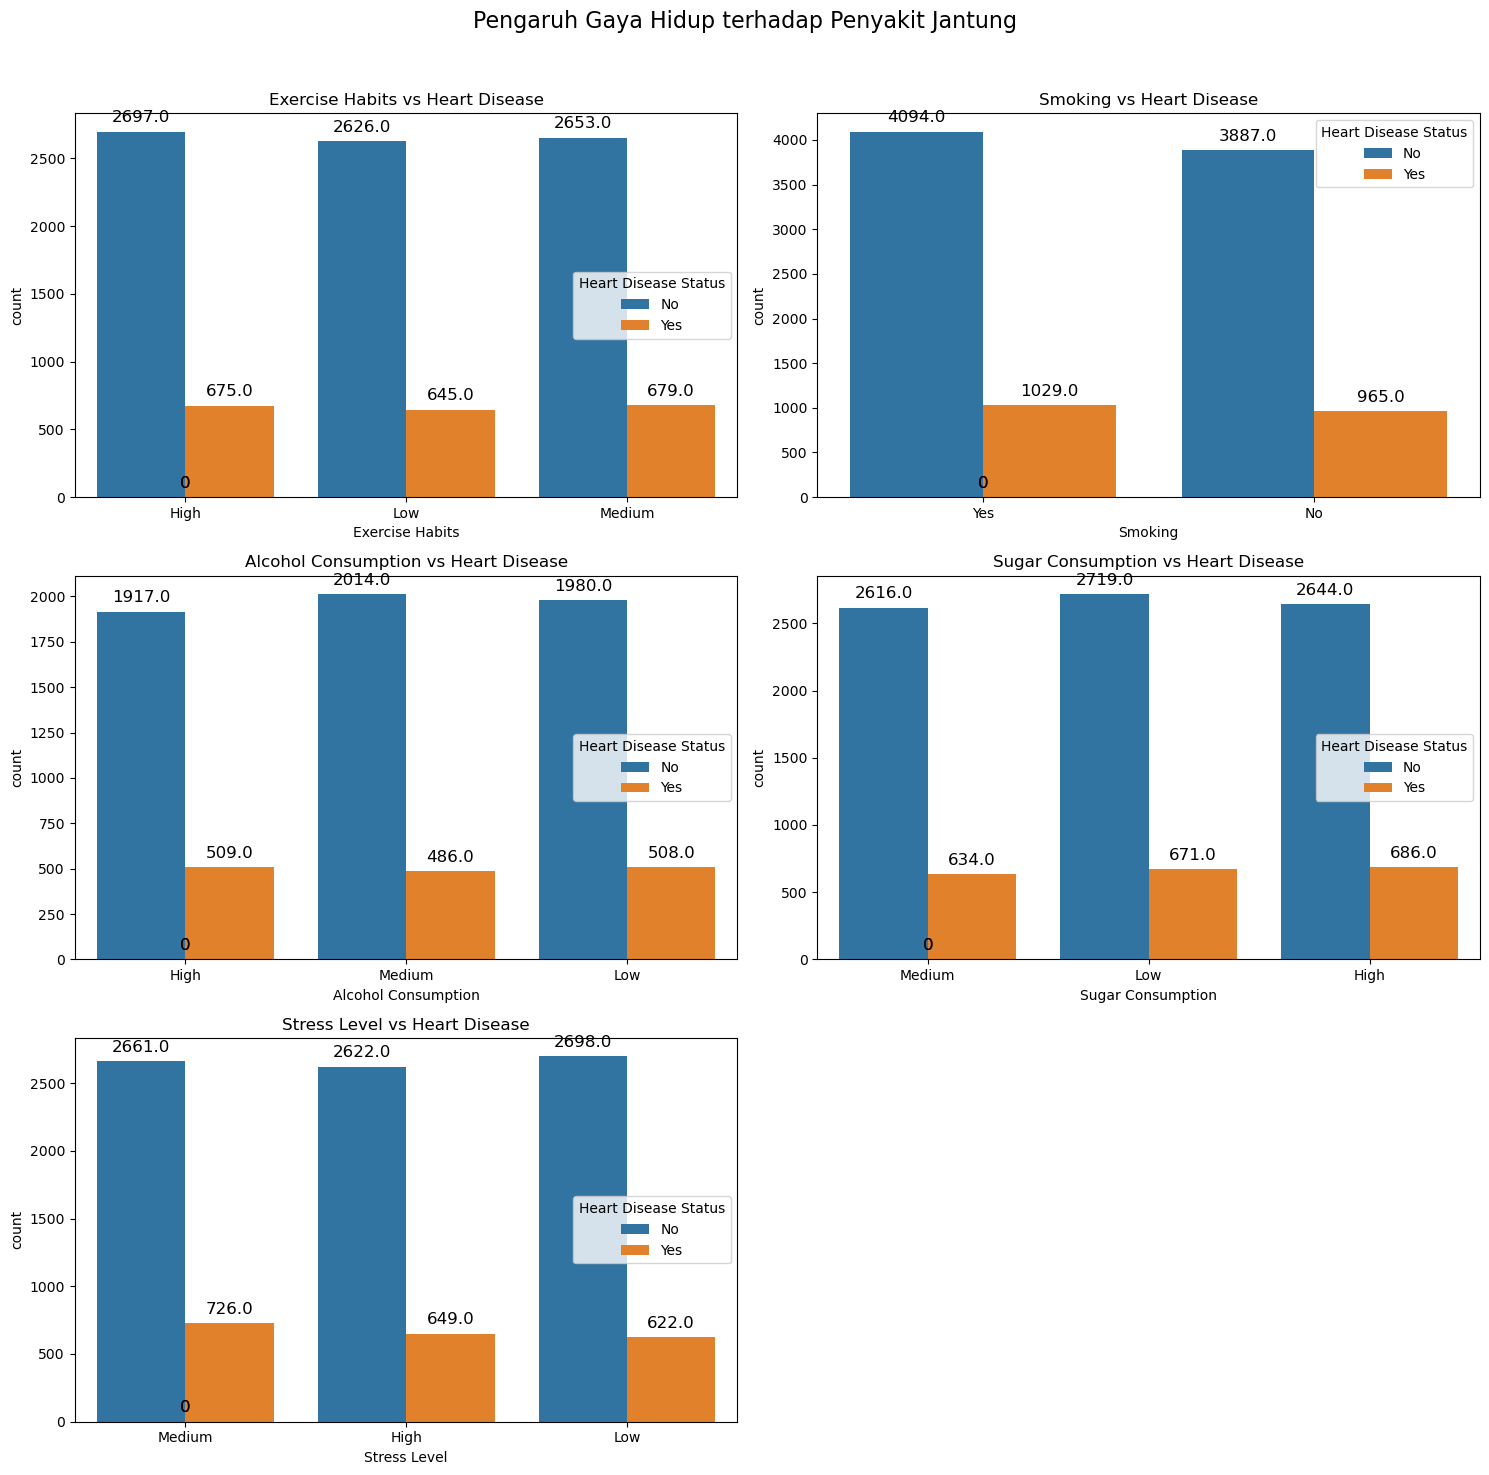

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle('Pengaruh Gaya Hidup terhadap Penyakit Jantung', fontsize=16)

# Gaya hidup vs Penyakit Jantung
sns.countplot(x='Exercise Habits', hue='Heart Disease Status', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Exercise Habits vs Heart Disease')
for p in axes[0, 0].patches:
    axes[0, 0].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                        textcoords='offset points')

sns.countplot(x='Smoking', hue='Heart Disease Status', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Smoking vs Heart Disease')
for p in axes[0, 1].patches:
    axes[0, 1].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                        textcoords='offset points')

sns.countplot(x='Alcohol Consumption', hue='Heart Disease Status', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Alcohol Consumption vs Heart Disease')
for p in axes[1, 0].patches:
    axes[1, 0].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                        textcoords='offset points')

sns.countplot(x='Sugar Consumption', hue='Heart Disease Status', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Sugar Consumption vs Heart Disease')
for p in axes[1, 1].patches:
    axes[1, 1].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                        textcoords='offset points')

sns.countplot(x='Stress Level', hue='Heart Disease Status', data=df, ax=axes[2, 0])
axes[2, 0].set_title('Stress Level vs Heart Disease')
for p in axes[2, 0].patches:
    axes[2, 0].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                        textcoords='offset points')

# Kosongkan subplot terakhir
axes[2, 1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Sama seperti penjelasan sebelumnya mengenai hubungan antara gaya hidup dan penyakit jantung, pada visualisasi tersebut dapat dilihat bahwa tingkat stres memiliki hubungan yang signifikan dengan penyakit jantung. Tingkat stres yang sedang (medium) memiliki risiko penyakit jantung terbesar, diikuti oleh tingkat stres tinggi (high) dan rendah (low). Sementara itu, faktor gaya hidup lainnya tidak menunjukkan pengaruh yang signifikan, karena jumlah individu yang terkena penyakit jantung perbedaannya tidak cukup besar di setiap kondisi.

## Hubungan antara variabel kesehatan (Blood Pressure, Cholesterol Level, Triglyceride Level, Fasting Blood Sugar, CRP Level, Homocysteine Level) terhadap penyakit jantung

Untuk uji korelasi disini menggunakan kendall

In [ ]:
# Salin kolom 'Heart Disease Status' dan mengubah menjadi numerik (1 untuk Yes, 0 untuk No)
heart_disease_status = df['Heart Disease Status'].map({'Yes': 1, 'No': 0})

# Variabel kesehatan
health_columns = ['Blood Pressure', 'Cholesterol Level', 'Triglyceride Level', 'Fasting Blood Sugar', 'CRP Level', 'Homocysteine Level']

# Mengabaikan dengan Menghapus baris yang memiliki missing values di health_columns dan target sementara karena ini masih EDA
df_clean = df.dropna(subset=health_columns + ['Heart Disease Status'])

# Melakukan uji korelasi Kendall untuk setiap variabel kesehatan terhadap Heart Disease Status
kendall_results = {}
for column in health_columns:
    tau, p_value = kendalltau(df_clean[column], df_clean['Heart Disease Status'])  # Menggunakan data bersih
    kendall_results[column] = {'Kendall Tau': tau, 'p-value': p_value}

# Menampilkan hasil uji Kendall
print("\nKendall Tau Correlation between Health Variables and Heart Disease Status:")
for column, result in kendall_results.items():
    print(f"{column}: Kendall Tau = {result['Kendall Tau']}, p-value = {result['p-value']}")


Kendall Tau Correlation between Health Variables and Heart Disease Status:
Blood Pressure: Kendall Tau = -0.010338941188376303, p-value = 0.2124516593328134
Cholesterol Level: Kendall Tau = 0.0018874492165692222, p-value = 0.8190804043707633
Triglyceride Level: Kendall Tau = 0.003092647471301235, p-value = 0.7073699255340973
Fasting Blood Sugar: Kendall Tau = -0.0036013822651817552, p-value = 0.6634256238855113
CRP Level: Kendall Tau = -0.004233231675974536, p-value = 0.6067694511380466
Homocysteine Level: Kendall Tau = 0.006259690364015513, p-value = 0.44661295909455645


Hasil uji korelasi Kendall Tau menunjukkan bahwa tidak ada hubungan yang signifikan antara variabel kesehatan (seperti tekanan darah, kolesterol, trigliserida, gula darah puasa, tingkat CRP, dan homosistein) dengan status penyakit jantung. Semua nilai Kendall Tau sangat rendah dan p-value lebih besar dari 0.05, yang menunjukkan bahwa variabel-variabel ini tidak memiliki korelasi yang signifikan dengan penyakit jantung dalam dataset ini. 

Selanjutnya melihat visualisasi antara variabel kesehatan dengan penyakit jantung

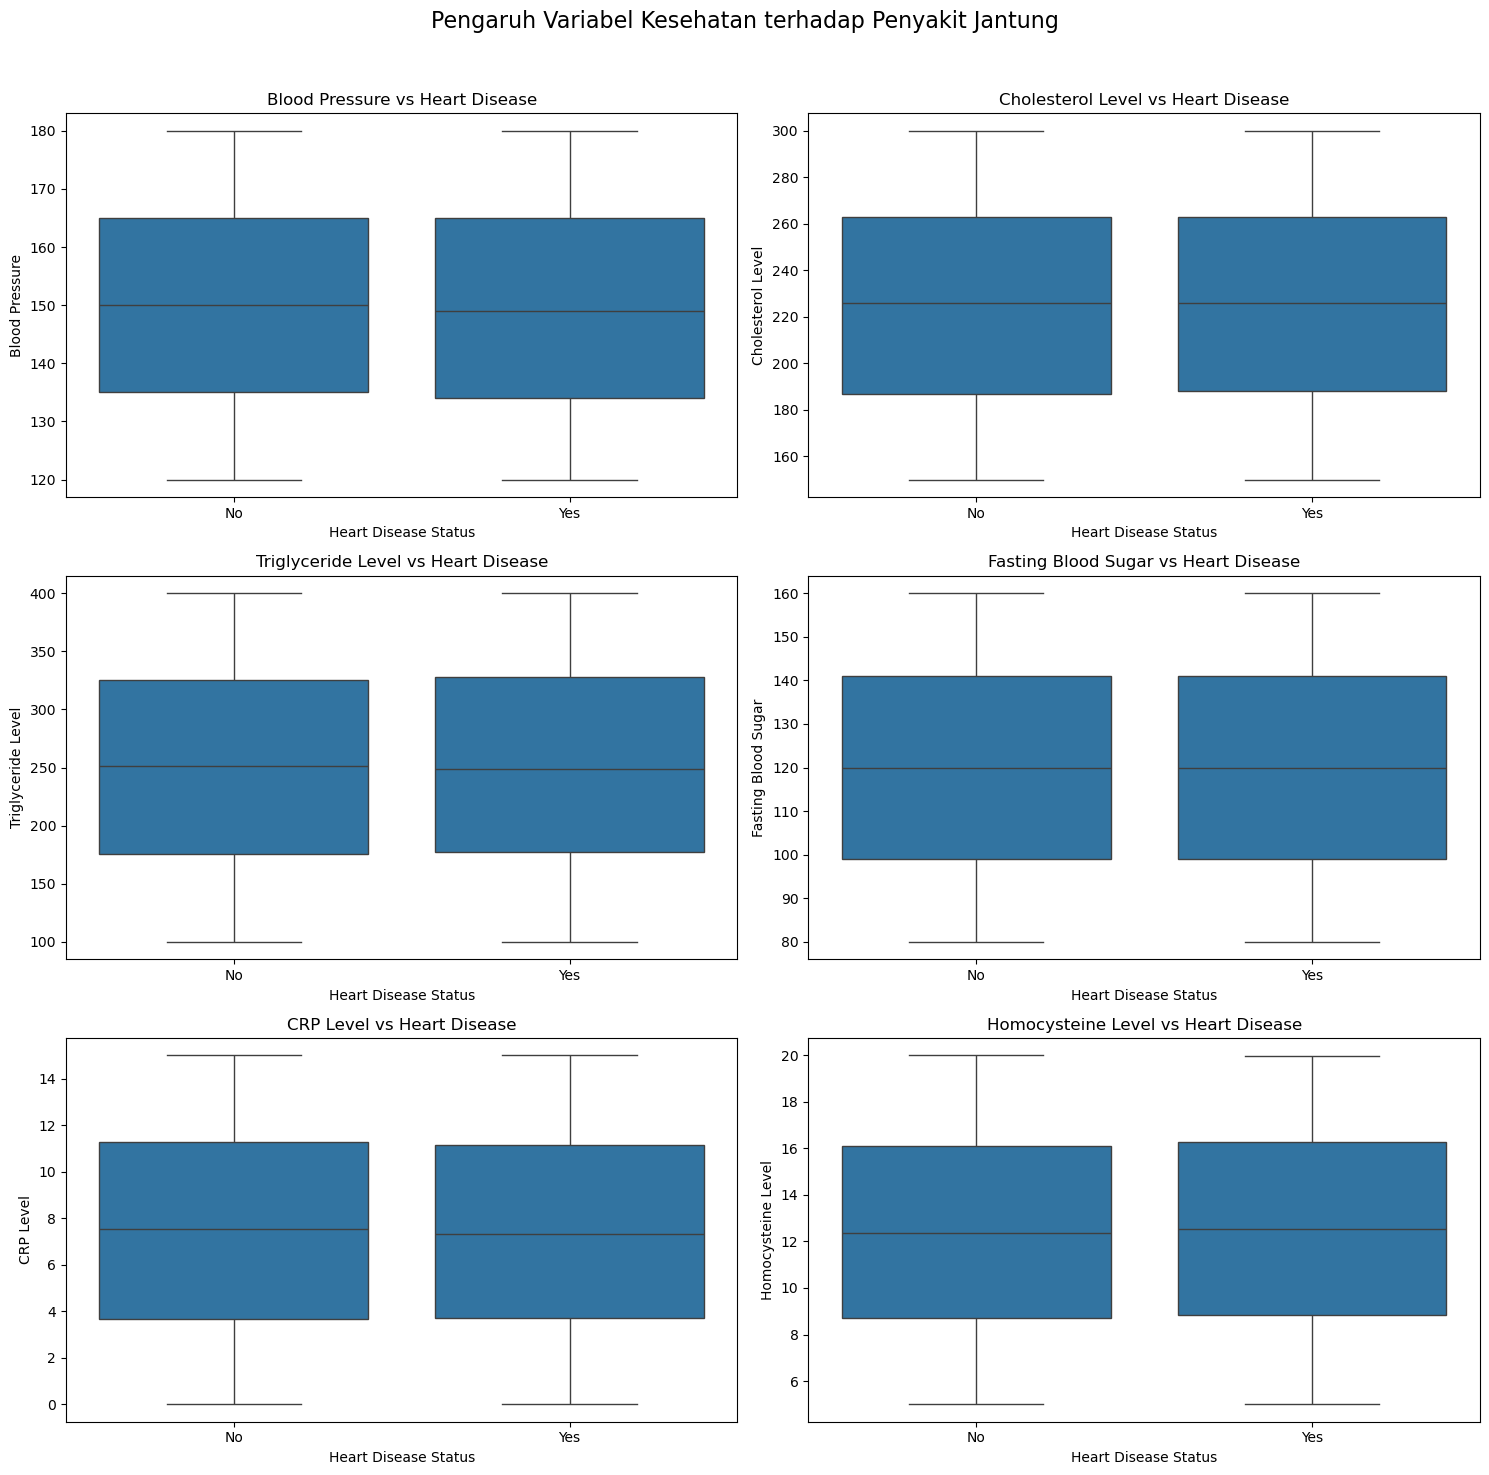

In [11]:
# List of variables for plotting
variables = ['Blood Pressure', 'Cholesterol Level', 'Triglyceride Level', 
             'Fasting Blood Sugar', 'CRP Level', 'Homocysteine Level']

# Plot
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle('Pengaruh Variabel Kesehatan terhadap Penyakit Jantung', fontsize=16)

# Menggunakan variabel kesehatan untuk plot
for i, var in enumerate(variables):
    ax = axes[i // 2, i % 2]  # Menentukan posisi subplot
    sns.boxplot(x='Heart Disease Status', y=var, data=df, ax=ax)
    ax.set_title(f'{var} vs Heart Disease')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Sama seperti hasil uji Kendall sebelumnya, dari boxplot juga terlihat bahwa tidak ada perbedaan yang mencolok antara orang yang memiliki penyakit jantung dan yang tidak pada semua variabel kesehatan tersebut. Sebaran data, nilai median, dan rentang antar kuartilnya cenderung mirip, baik itu pada tekanan darah, kolesterol, trigliserida, gula darah puasa, CRP, maupun homosistein.

## Pengaruh usia dan BMI terhadap penyakit jantung

Disini saya menggunakan uji kendall

In [12]:
# Salin kolom 'Heart Disease Status' dan mengubah menjadi numerik (1 untuk Yes, 0 untuk No)
heart_disease_status = df['Heart Disease Status'].map({'Yes': 1, 'No': 0})

# Variabel yang ingin diuji
features = ['Age', 'BMI']

# # Mengabaikan dan Menghapus baris yang memiliki missing values di health_columns dan target sementara karena ini masih EDA
df_clean = df.dropna(subset=features + ['Heart Disease Status'])

# Melakukan uji korelasi Kendall
kendall_results = {}
for column in features:
    tau, p_value = kendalltau(df_clean[column], heart_disease_status.loc[df_clean.index])
    kendall_results[column] = {'Kendall Tau': tau, 'p-value': p_value}

# Menampilkan hasil uji Kendall
print("\nKendall Tau Correlation between Age/BMI and Heart Disease Status:")
for column, result in kendall_results.items():
    print(f"{column}: Kendall Tau = {result['Kendall Tau']}, p-value = {result['p-value']}")



Kendall Tau Correlation between Age/BMI and Heart Disease Status:
Age: Kendall Tau = -0.00749796911364275, p-value = 0.3635181780959257
BMI: Kendall Tau = 0.01587629892595845, p-value = 0.05246701280461137


Hasil uji korelasi Kendall Tau menunjukkan bahwa usia dan BMI tidak memiliki hubungan yang signifikan dengan penyakit jantung dalam dataset ini. Nilai Kendall Tau untuk keduanya sangat kecil (dekat nol), yang artinya korelasinya sangat lemah. Selain itu, nilai p-value untuk usia sekitar 0.36 dan untuk BMI sekitar 0.05 — meskipun p-value BMI mendekati batas 0.05, namun tetap belum cukup kuat untuk disimpulkan signifikan. Jadi, bisa dikatakan bahwa tidak ada bukti kuat bahwa usia atau BMI berkaitan langsung dengan status penyakit jantung pada data ini.

Selanjutnya membuat visualisasi boxplot

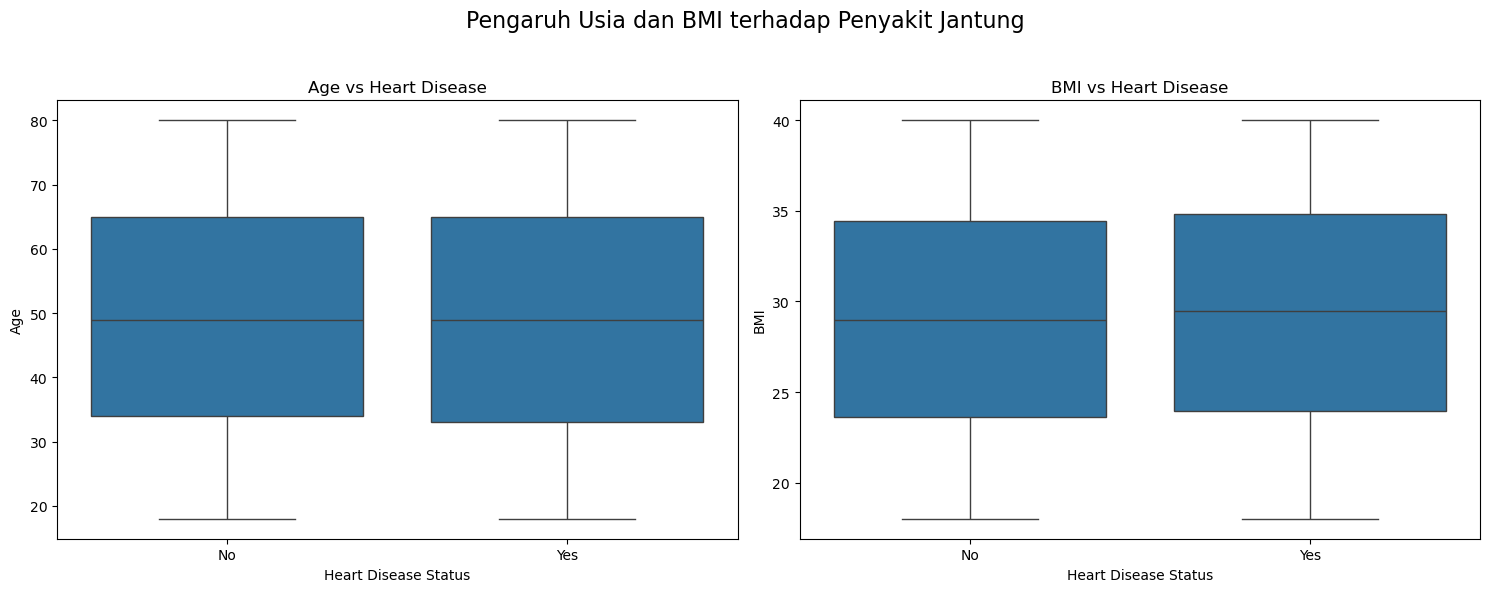

In [13]:
# List of variables untuk plot
variables = ['Age', 'BMI']

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Pengaruh Usia dan BMI terhadap Penyakit Jantung', fontsize=16)

# Plot untuk setiap variabel
for i, var in enumerate(variables):
    ax = axes[i]
    sns.boxplot(x='Heart Disease Status', y=var, data=df, ax=ax)
    ax.set_title(f'{var} vs Heart Disease')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Dari hasil boxplot juga terlihat bahwa rentang nilai, median, dan interkuartil (IQR) untuk usia dan BMI cenderung mirip antara kelompok yang memiliki penyakit jantung dan yang tidak.

## Pengaruh keturunan penyakit jantung menderita penyakit jantung

Disini saya menggunakan uji chisquare

H0: There is no relationship between Family Heart Disease and Heart Disease

H1: There is a relationship between Family Heart Disease and Heart Disease

In [16]:
# Buat tabel kontingensi
contingency_table = pd.crosstab(df['Family Heart Disease'], df['Heart Disease Status'])

# Hitung chi-square
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

# Tampilkan hasil
print(f"Chi-square Statistic: {chi2_stat}")
print(f"p-value: {p_val}")

Chi-square Statistic: 0.4306519216111665
p-value: 0.5116692335334628


Berdasarkan hasil uji chi-square yang menunjukkan p-value = 0.511, maka karena p-value > 0.05, hipotesis nol (H0) tidak ditolak. Artinya, tidak ditemukan hubungan yang signifikan antara riwayat penyakit jantung dalam keluarga dengan penyakit jantung pada individu dalam dataset ini.

Selanjutnya membuat visualisasi barchart

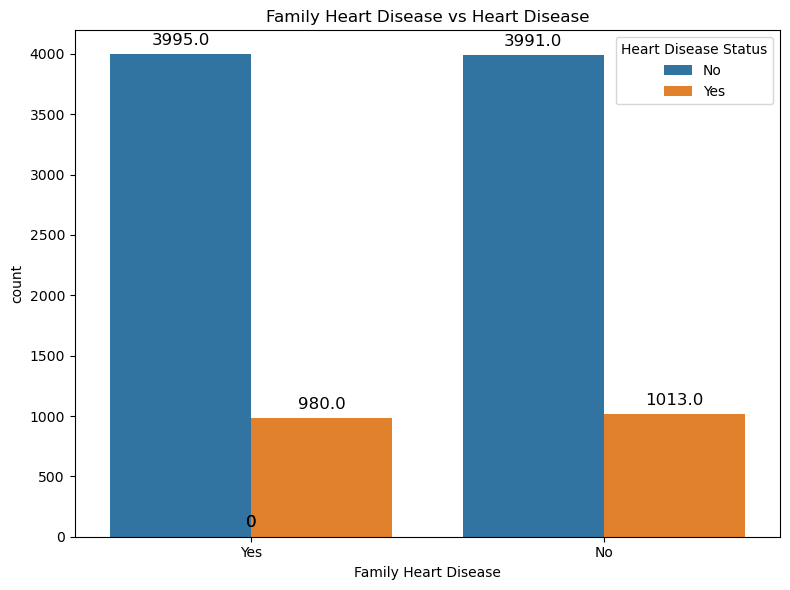

In [17]:
# Plot
plt.figure(figsize=(8, 6))
plt.title('Hubungan Family Heart Disease dengan Penyakit Jantung', fontsize=16)

# Family Heart Disease vs Heart Disease
sns.countplot(x='Family Heart Disease', hue='Heart Disease Status', data=df)
plt.title('Family Heart Disease vs Heart Disease')

# Menambahkan angka pada setiap bar
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                       textcoords='offset points')

plt.tight_layout()
plt.show()


Berdasarkan gambar tersebut, dapat dilihat bahwa perbedaan antara individu yang memiliki riwayat keluarga dengan penyakit jantung dan yang tidak memiliki riwayat keluarga penyakit jantung hanya sedikit berbeda dalam hal status penderita penyakit jantung atau bukan.

## Jumlah antara penderita dan bukan penderita penyakit jantung

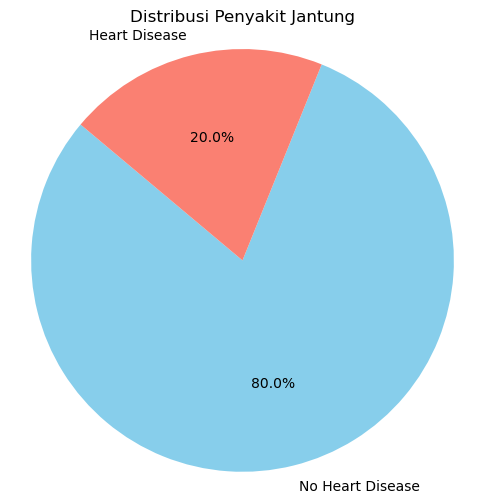

Heart Disease Status
No     8000
Yes    2000
Name: count, dtype: int64

In [20]:
# Hitung jumlah masing-masing kategori
counts = df['Heart Disease Status'].value_counts()
labels = ['No Heart Disease', 'Heart Disease']  # 0: No, 1: Yes

# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'salmon'])
plt.title('Distribusi Penyakit Jantung')
plt.axis('equal')  # Agar pie chart bulat
plt.show()

df['Heart Disease Status'].value_counts()

Berdasarkan gambar tersebut, sebanyak 80% responden tidak memiliki penyakit jantung, sementara hanya 20% yang mengidap penyakit tersebut. Hal ini menunjukkan bahwa data bersifat imbalance atau tidak seimbang. Data imbalance dapat membuat model cenderung lebih akurat dalam memprediksi kelas mayoritas (tidak memiliki penyakit jantung) dan kurang sensitif terhadap kelas minoritas (penderita penyakit jantung). Oleh karena itu perlu mengatasi data imbalance di feature engineering nanti.

## Proporsi penderita penyakit jantung antara laki-laki dan perempuan.

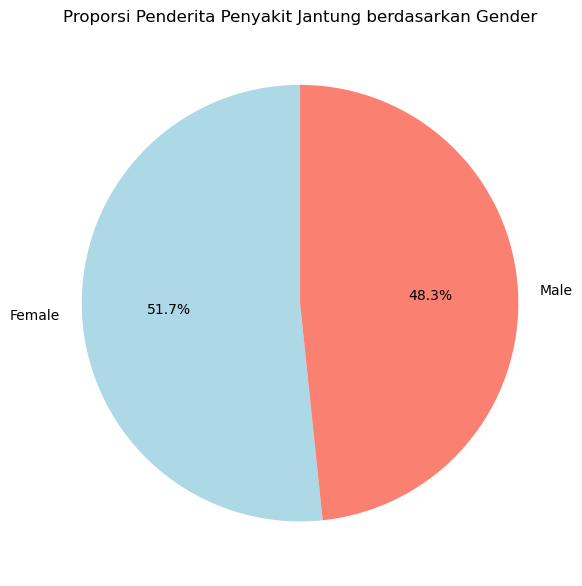

In [ ]:
# Salin dan siapkan data
df_gender = df[['Gender', 'Heart Disease Status']].dropna()

# Hitung proporsi penderita penyakit jantung untuk tiap gender
prop_gender = pd.crosstab(df_gender['Gender'], df_gender['Heart Disease Status'], normalize='index') * 100

# Ambil hanya proporsi 'Yes' (yang menderita penyakit jantung)
heart_disease_by_gender = prop_gender['Yes']

# Pie chart
plt.figure(figsize=(6, 6))
colors = ['lightblue', 'salmon']  # Sesuaikan warna jika gender hanya Male/Female
heart_disease_by_gender.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=colors)

plt.title('Proporsi Penderita Penyakit Jantung berdasarkan Gender')
plt.ylabel('')  # Menghilangkan label y
plt.tight_layout()
plt.show()

Berdasarkan proporsi penderita penyakit jantung berdasarkan gender, terlihat bahwa persentase perempuan yang menderita penyakit jantung sedikit lebih tinggi dibandingkan laki-laki. Sebanyak 51.7% perempuan dalam data ini teridentifikasi memiliki penyakit jantung, sedangkan pada laki-laki angkanya sedikit lebih rendah, yaitu 48.3%. Meskipun perbedaannya tidak terlalu besar, hal ini menunjukkan bahwa proporsi penderita penyakit jantung sedikit lebih tinggi pada kelompok perempuan dibandingkan laki-laki dalam dataset ini. 

## Pengaruh Pola Tidur terhadap Penyakit Jantung

In [25]:
# Salin kolom 'Heart Disease Status' dan ubah menjadi numerik
heart_disease_status = df['Heart Disease Status'].map({'Yes': 1, 'No': 0})

# Variabel yang ingin diuji: Pola Tidur
features = ['Sleep Hours']

# Hapus baris dengan nilai NaN di Sleep Hours dan Heart Disease Status
df_clean = df.dropna(subset=features + ['Heart Disease Status'])

# Uji korelasi Kendall Tau
kendall_results = {}
for column in features:
    tau, p_value = kendalltau(df_clean[column], heart_disease_status.loc[df_clean.index])
    kendall_results[column] = {'Kendall Tau': tau, 'p-value': p_value}

# Tampilkan hasil
print("\nKendall Tau Correlation between Sleep Hours and Heart Disease Status:")
for column, result in kendall_results.items():
    print(f"{column}: Kendall Tau = {result['Kendall Tau']}, p-value = {result['p-value']}")



Kendall Tau Correlation between Sleep Hours and Heart Disease Status:
Sleep Hours: Kendall Tau = -0.003120663577365319, p-value = 0.7026947649161778


Hasil uji korelasi Kendall Tau antara jumlah jam tidur dan status penyakit jantung menunjukkan nilai Kendall Tau sebesar -0.0031 dan p-value sebesar 0.703. Karena p-value lebih besar dari 0.05, ini menunjukkan bahwa tidak ada hubungan yang signifikan antara jumlah jam tidur dengan risiko penyakit jantung dalam dataset ini.

Selanjutnya membuat visualisasi boxplot antara jam tidur dengan penyakit jantung

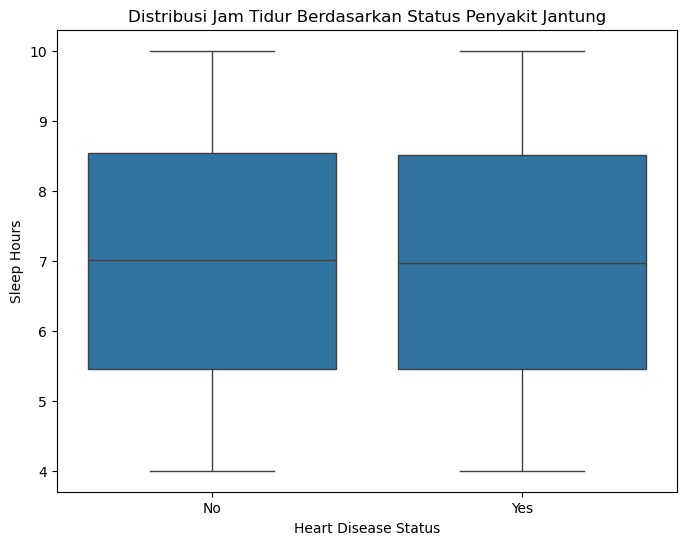

In [26]:
# Plotting boxplot untuk Sleep Hours berdasarkan Heart Disease Status
plt.figure(figsize=(8, 6))
sns.boxplot(x='Heart Disease Status', y='Sleep Hours', data=df)
plt.title('Distribusi Jam Tidur Berdasarkan Status Penyakit Jantung')
plt.show()


Jika dilihat dari boxplot, rentang (range), median, dan jarak interquartil (IQR) antara individu yang memiliki penyakit jantung dan yang tidak cenderung serupa. Artinya, distribusi jam tidur pada kedua kelompok ini tidak menunjukkan perbedaan yang mencolok. Kedua kelompok memiliki nilai median yang hampir sama dan juga sebaran data yang mirip, yang menunjukkan bahwa pola tidur tidak menunjukkan perbedaan signifikan antara penderita dan bukan penderita penyakit jantung dalam dataset ini.

Setelah melakukan EDA, selanjutnya melakukan Feature Engineering

# BAB 5 - Feature Engineering

Saya akan mengecek cardinality terlebih dahulu pada kolom categorical

## Check Cardinality

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   9971 non-null   float64
 1   Gender                9981 non-null   object 
 2   Blood Pressure        9981 non-null   float64
 3   Cholesterol Level     9970 non-null   float64
 4   Exercise Habits       9975 non-null   object 
 5   Smoking               9975 non-null   object 
 6   Family Heart Disease  9979 non-null   object 
 7   Diabetes              9970 non-null   object 
 8   BMI                   9978 non-null   float64
 9   High Blood Pressure   9974 non-null   object 
 10  Low HDL Cholesterol   9975 non-null   object 
 11  High LDL Cholesterol  9974 non-null   object 
 12  Alcohol Consumption   7414 non-null   object 
 13  Stress Level          9978 non-null   object 
 14  Sleep Hours           9975 non-null   float64
 15  Sugar Consumption   

In [29]:
# List kolom kategorik yang ingin dicek kardinalitasnya
categorical_columns = ['Gender', 'Exercise Habits', 'Smoking', 'Family Heart Disease', 
                       'Diabetes', 'High Blood Pressure', 'Low HDL Cholesterol', 
                       'High LDL Cholesterol', 'Alcohol Consumption', 'Stress Level', 
                       'Sugar Consumption']

# Mengecek kardinalitas pada setiap kolom kategorik
for column in categorical_columns:
    print(f"Kardinalitas untuk kolom {column}: {df[column].unique()}")
    print(f"Jumlah nilai unik pada kolom {column}: {len(df[column].unique())}")

Kardinalitas untuk kolom Gender: ['Male' 'Female' nan]
Jumlah nilai unik pada kolom Gender: 3
Kardinalitas untuk kolom Exercise Habits: ['High' 'Low' 'Medium' nan]
Jumlah nilai unik pada kolom Exercise Habits: 4
Kardinalitas untuk kolom Smoking: ['Yes' 'No' nan]
Jumlah nilai unik pada kolom Smoking: 3
Kardinalitas untuk kolom Family Heart Disease: ['Yes' 'No' nan]
Jumlah nilai unik pada kolom Family Heart Disease: 3
Kardinalitas untuk kolom Diabetes: ['No' 'Yes' nan]
Jumlah nilai unik pada kolom Diabetes: 3
Kardinalitas untuk kolom High Blood Pressure: ['Yes' 'No' nan]
Jumlah nilai unik pada kolom High Blood Pressure: 3
Kardinalitas untuk kolom Low HDL Cholesterol: ['Yes' 'No' nan]
Jumlah nilai unik pada kolom Low HDL Cholesterol: 3
Kardinalitas untuk kolom High LDL Cholesterol: ['No' 'Yes' nan]
Jumlah nilai unik pada kolom High LDL Cholesterol: 3
Kardinalitas untuk kolom Alcohol Consumption: ['High' 'Medium' 'Low' nan]
Jumlah nilai unik pada kolom Alcohol Consumption: 4
Kardinalitas u

Terdapat nan pada semua kolom - kolom tersebut. Jika dilihat dari jumlah unique columnya, yaitu antara 3 sampai 4 yang menunjukan bahwa kolom - kolom tersebut memiliki low cardinality. Untuk yang nan akan dihandle dan selanjutnya melakukan spliting data terlebih dahulu

## Train Test Split

In [30]:
# Membagi dataset menjadi fitur (X) dan target (y)
X = df.drop(columns='Heart Disease Status')  # Menghapus kolom 'Heart Disease Status' untuk fitur
y = df['Heart Disease Status']  # Menetapkan kolom 'Heart Disease Status' sebagai target

In [ ]:
X #Menampilkan X

,Age,Gender,Blood Pressure,Cholesterol Level,Exercise Habits,Smoking,Family Heart Disease,Diabetes,BMI,High Blood Pressure,Low HDL Cholesterol,High LDL Cholesterol,Alcohol Consumption,Stress Level,Sleep Hours,Sugar Consumption,Triglyceride Level,Fasting Blood Sugar,CRP Level,Homocysteine Level
0,56.0,Male,153.0,155.0,High,Yes,Yes,No,24.991591,Yes,Yes,No,High,Medium,7.633228,Medium,342.0,NaN,12.969246,12.387250
1,69.0,Female,146.0,286.0,High,No,Yes,Yes,25.221799,No,Yes,No,Medium,High,8.744034,Medium,133.0,157.0,9.355389,19.298875
2,46.0,Male,126.0,216.0,Low,No,No,No,29.855447,No,Yes,Yes,Low,Low,4.440440,Low,393.0,92.0,12.709873,11.230926
3,32.0,Female,122.0,293.0,High,Yes,Yes,No,24.130477,Yes,No,Yes,Low,High,5.249405,High,293.0,94.0,12.509046,5.961958
4,60.0,Male,166.0,242.0,Low,Yes,Yes,Yes,20.486289,Yes,No,No,Low,High,7.030971,High,263.0,154.0,10.381259,8.153887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,25.0,Female,136.0,243.0,Medium,Yes,No,No,18.788791,Yes,No,Yes,Medium,High,6.834954,Medium,343.0,133.0,3.588814,19.132004
9996,38.0,Male,172.0,154.0,Medium,No,No,No,31.856801,Yes,No,Yes,NaN,High,8.247784,Low,377.0,83.0,2.658267,9.715709
9997,73.0,Male,152.0,201.0,High,Yes,No,Yes,26.899911,No,Yes,Yes,NaN,Low,4.436762,Low,248.0,88.0,4.408867,9.492429
9998,23.0,Male,142.0,299.0,Low,Yes,No,Yes,34.964026,Yes,No,Yes,Medium,High,8.526329,Medium,113.0,153.0,7.215634,11.873486


In [ ]:
y #Menampilkan y

0        No
1        No
2        No
3        No
4        No
       ... 
9995    Yes
9996    Yes
9997    Yes
9998    Yes
9999    Yes
Name: Heart Disease Status, Length: 10000, dtype: object

In [35]:
#Split train test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=107, stratify=y)
print(f'train size : {X_train.shape}')
print(f'test size : {X_test.shape}')
X_train.head()

train size : (7500, 20)
test size : (2500, 20)


,Age,Gender,Blood Pressure,Cholesterol Level,Exercise Habits,Smoking,Family Heart Disease,Diabetes,BMI,High Blood Pressure,Low HDL Cholesterol,High LDL Cholesterol,Alcohol Consumption,Stress Level,Sleep Hours,Sugar Consumption,Triglyceride Level,Fasting Blood Sugar,CRP Level,Homocysteine Level
2403,20.0,NaN,135.0,155.0,High,No,No,Yes,38.974130,Yes,Yes,No,Medium,Medium,5.177439,High,328.0,100.0,7.147045,16.562374
8787,55.0,Female,126.0,236.0,High,Yes,Yes,No,32.158776,No,No,No,High,Medium,8.129801,Medium,328.0,141.0,2.457851,6.214357
6444,43.0,Female,127.0,214.0,Medium,No,No,No,35.907866,No,No,Yes,NaN,Medium,6.533724,Low,151.0,101.0,11.019466,11.300061
2606,75.0,Female,126.0,207.0,Low,Yes,Yes,No,35.977698,Yes,Yes,Yes,NaN,High,9.284957,Medium,262.0,97.0,5.404271,13.833534
890,56.0,Male,131.0,279.0,Low,No,Yes,No,39.214799,Yes,Yes,No,High,Medium,8.578821,Medium,205.0,120.0,5.089601,18.768354


Jumlah data train ada 7.500 dan jumlah data test ada 2.500

Selanjutnya sebelum handling missing value, cek distribusi data terlebih dahulu.

## Cek Distribusi Data

Selanjutnya mengecek distribusi data pada kolom numerik

In [38]:
# Menghitung skewness untuk kolom numerik
numerical_columns = X_train.select_dtypes(include=['float64']).columns
skewness = X_train[numerical_columns].skew()

# Menampilkan hasil skewness
print(skewness)

Age                   -0.009106
Blood Pressure         0.016170
Cholesterol Level     -0.009272
BMI                   -0.018354
Sleep Hours           -0.006537
Triglyceride Level     0.011319
Fasting Blood Sugar    0.003250
CRP Level             -0.014896
Homocysteine Level     0.008453
dtype: float64


Berdasarkan hasil skewness pada semua kolom numerik tersebut, rangenya ada diantara -0.5 dan 0.5 yang menunjukan bahwa distribusi kolom-kolom tersebut mendekati normal.

Selanjutnya melakukan handle missing value

## Handle Missing Value

In [41]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7500 entries, 2403 to 8014
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   7480 non-null   float64
 1   Gender                7485 non-null   object 
 2   Blood Pressure        7485 non-null   float64
 3   Cholesterol Level     7480 non-null   float64
 4   Exercise Habits       7481 non-null   object 
 5   Smoking               7486 non-null   object 
 6   Family Heart Disease  7488 non-null   object 
 7   Diabetes              7479 non-null   object 
 8   BMI                   7485 non-null   float64
 9   High Blood Pressure   7481 non-null   object 
 10  Low HDL Cholesterol   7483 non-null   object 
 11  High LDL Cholesterol  7479 non-null   object 
 12  Alcohol Consumption   5545 non-null   object 
 13  Stress Level          7483 non-null   object 
 14  Sleep Hours           7478 non-null   float64
 15  Sugar Consumption     7

In [39]:
X_train.isnull().sum()

Age                       20
Gender                    15
Blood Pressure            15
Cholesterol Level         20
Exercise Habits           19
Smoking                   14
Family Heart Disease      12
Diabetes                  21
BMI                       15
High Blood Pressure       19
Low HDL Cholesterol       17
High LDL Cholesterol      21
Alcohol Consumption     1955
Stress Level              17
Sleep Hours               22
Sugar Consumption         22
Triglyceride Level        17
Fasting Blood Sugar       17
CRP Level                 23
Homocysteine Level        17
dtype: int64

Setiap kolom pada X_train memiliki missing value, dan untuk mengidentifikasi polanya, kita dapat menggunakan visualisasi dari library Missingno. Library ini memudahkan analisis data yang hilang melalui berbagai bentuk visual seperti matrix plot, bar chart, heatmap, dan dendrogram. 

Pada fungsi missingno.heatmap(), hubungan antar pola missing value diukur berdasarkan kecenderungan dua kolom memiliki data hilang di baris yang sama. Misalnya, jika kolom A dan B sering sama-sama hilang, korelasinya tinggi. Sebaliknya, jika satu hilang dan yang lain tidak, korelasinya bisa negatif. Korelasi rendah mengindikasikan bahwa missing value kemungkinan bersifat acak (MCAR). Dengan memahami pola ini, kita bisa menentukan metode penanganan yang lebih tepat seperti imputasi atau penghapusan data.

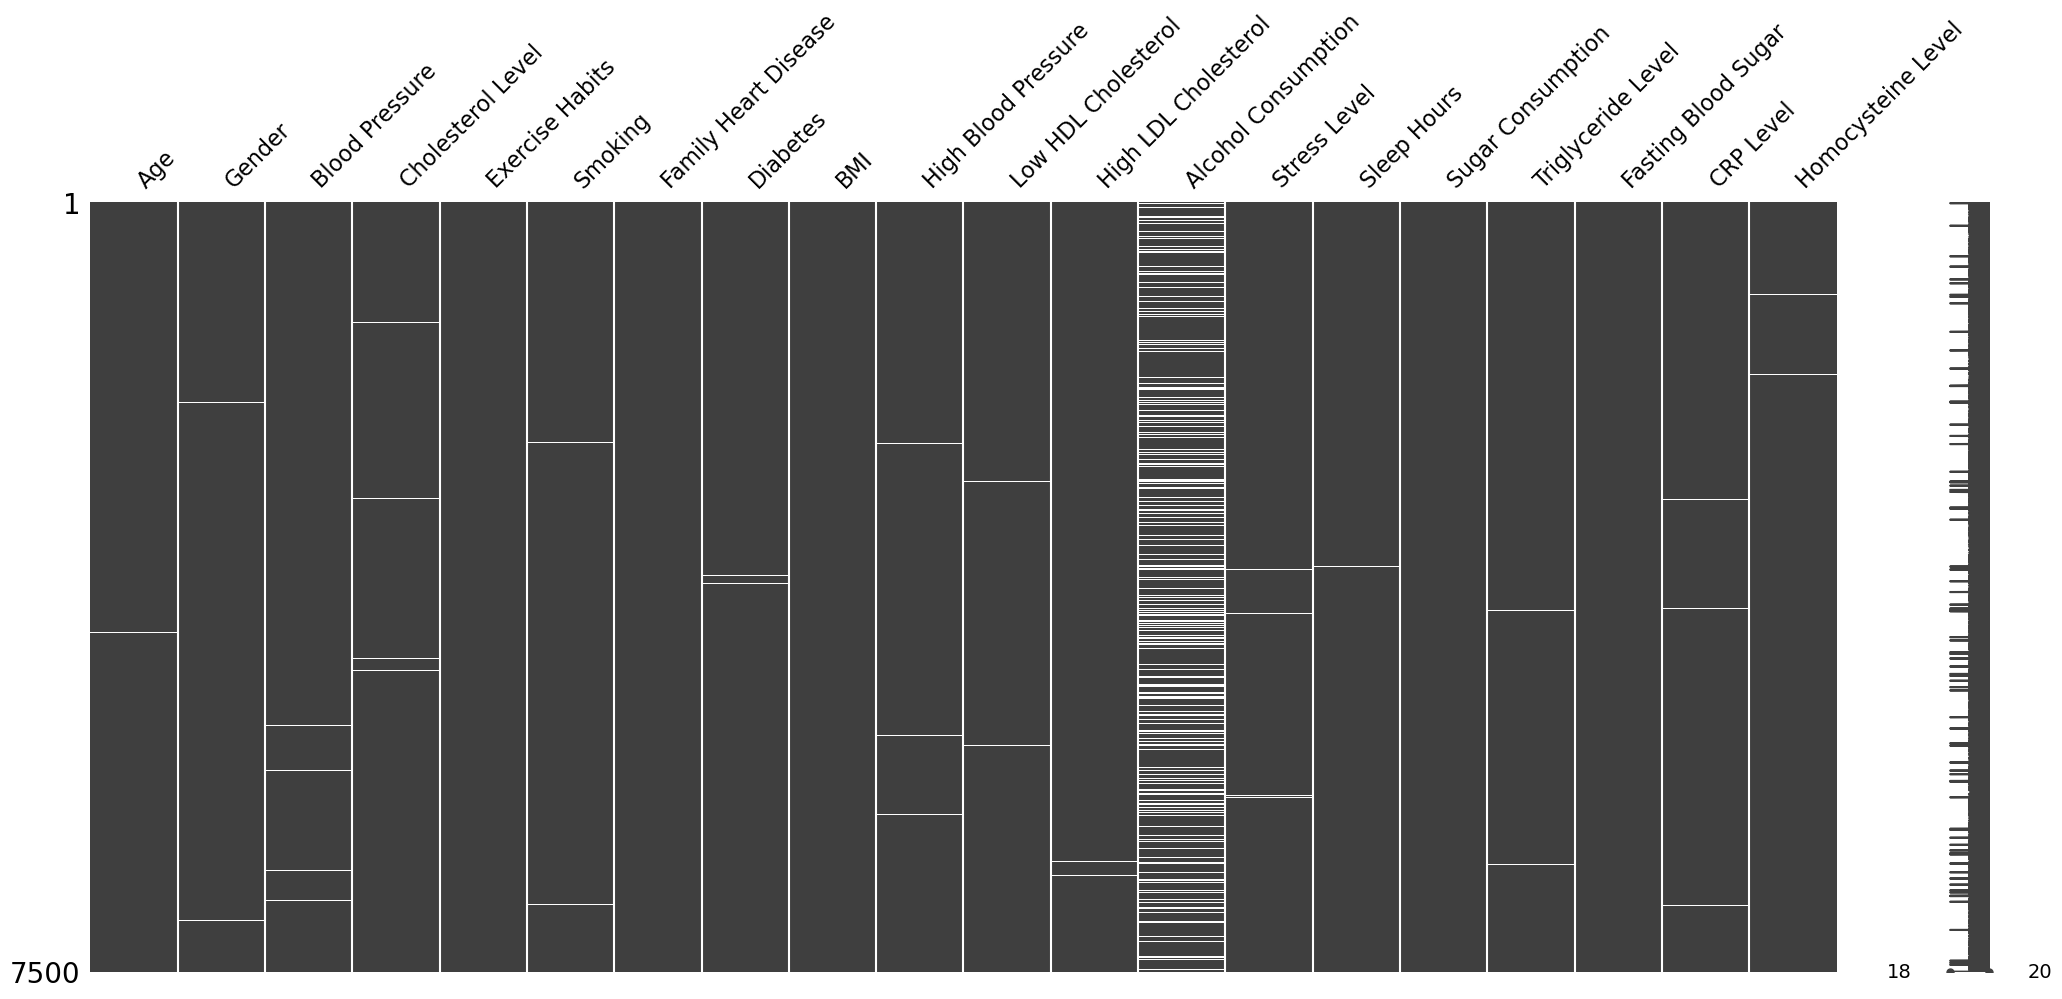

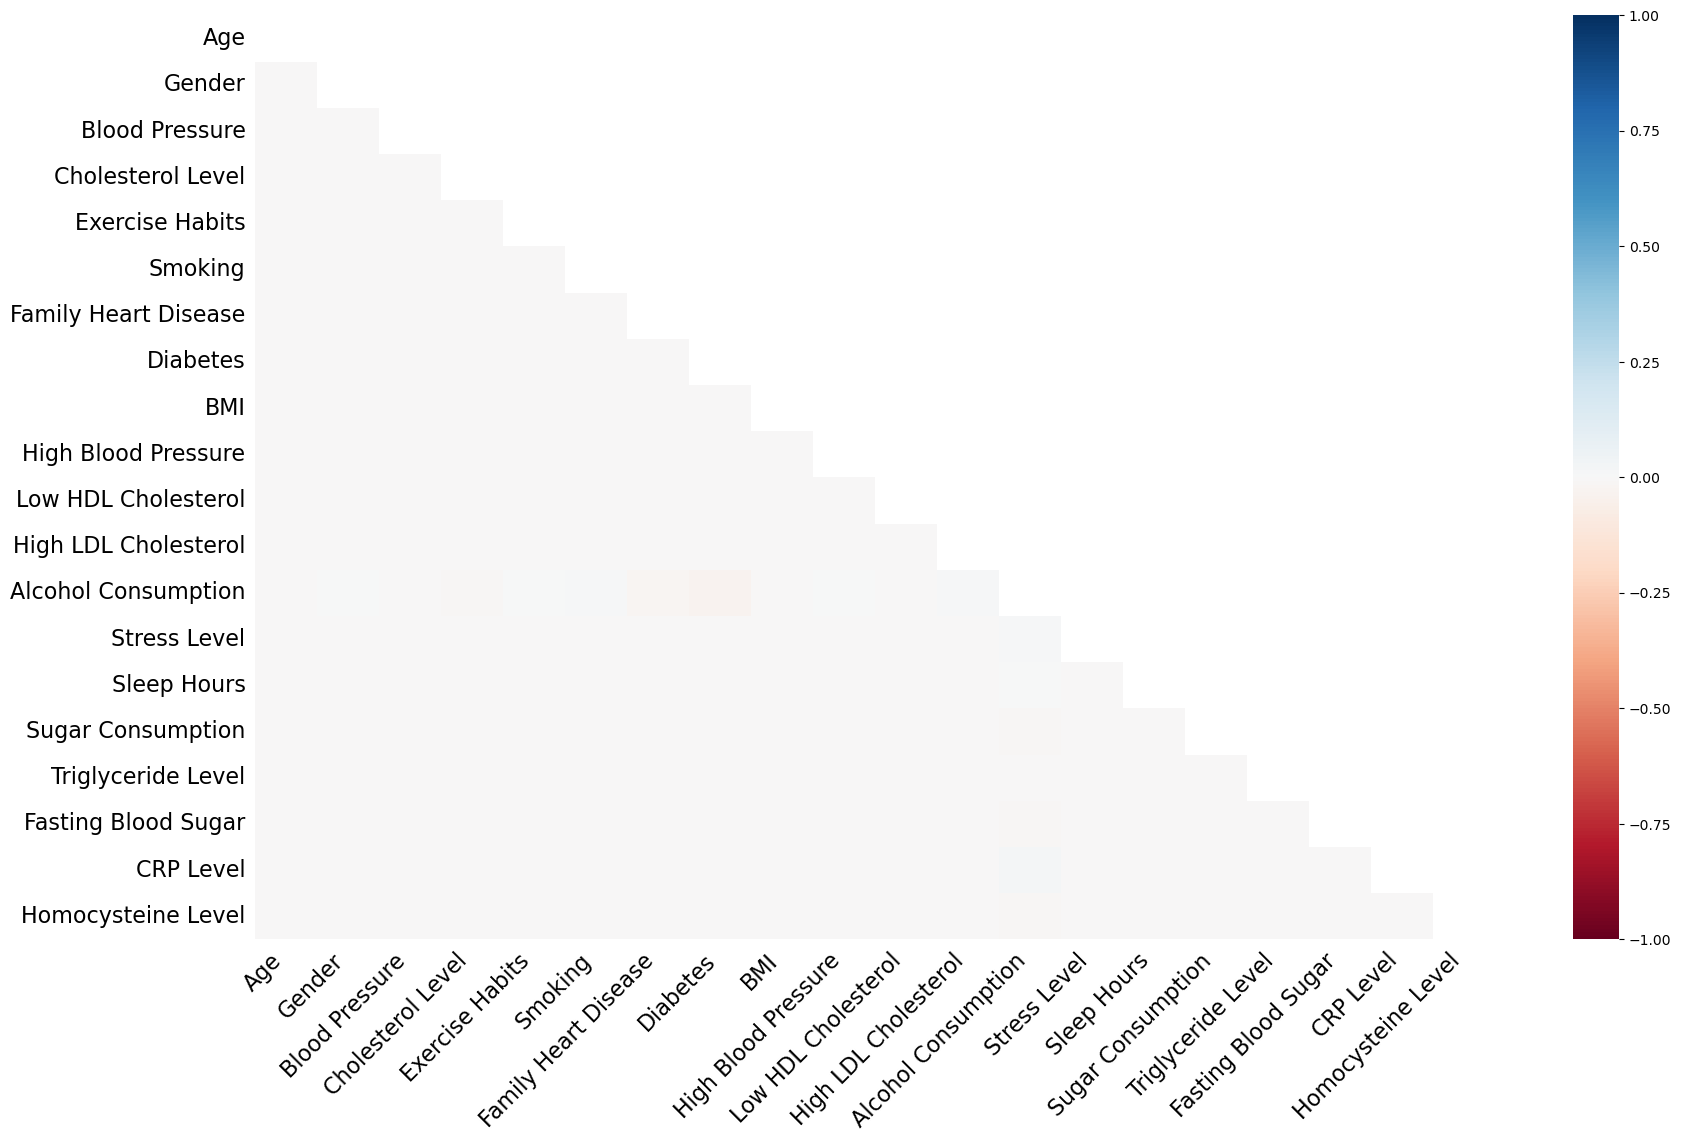

In [47]:
# Visualisasi missing data dengan matrix plot
msno.matrix(X_train)
plt.show()

# Visualisasi korelasi antara missing data di kolom-kolom yang ada
msno.heatmap(X_train)
plt.show()

In [51]:
# Boolean matrix dari missing values
missing_bool = X_train.isnull()

# Hitung korelasi antar pola missing value
missing_corr = missing_bool.corr(method='pearson')

# Tampilkan skor korelasi
missing_corr

,Age,Gender,Blood Pressure,Cholesterol Level,Exercise Habits,Smoking,Family Heart Disease,Diabetes,BMI,High Blood Pressure,Low HDL Cholesterol,High LDL Cholesterol,Alcohol Consumption,Stress Level,Sleep Hours,Sugar Consumption,Triglyceride Level,Fasting Blood Sugar,CRP Level,Homocysteine Level
Age,1.000000,-0.002315,-0.002315,-0.002674,-0.002606,-0.002236,-0.002070,-0.002740,-0.002315,-0.002606,-0.002465,-0.002740,-0.001256,-0.002465,-0.002805,-0.002805,-0.002465,-0.002465,-0.002868,-0.002465
Gender,-0.002315,1.000000,-0.002004,-0.002315,-0.002256,-0.001936,-0.001792,-0.002372,-0.002004,-0.002256,-0.002134,-0.002372,0.000612,-0.002134,-0.002428,-0.002428,-0.002134,-0.002134,-0.002483,-0.002134
Blood Pressure,-0.002315,-0.002004,1.000000,-0.002315,-0.002256,-0.001936,-0.001792,-0.002372,-0.002004,-0.002256,-0.002134,-0.002372,-0.006186,-0.002134,-0.002428,-0.002428,-0.002134,-0.002134,-0.002483,-0.002134
Cholesterol Level,-0.002674,-0.002315,-0.002315,1.000000,-0.002606,-0.002236,-0.002070,-0.002740,-0.002315,-0.002606,-0.002465,-0.002740,-0.013035,-0.002465,-0.002805,-0.002805,-0.002465,-0.002465,-0.002868,-0.002465
Exercise Habits,-0.002606,-0.002256,-0.002256,-0.002606,1.000000,-0.002179,-0.002017,-0.002670,-0.002256,-0.002540,-0.002402,-0.002670,0.006328,-0.002402,-0.002733,-0.002733,-0.002402,-0.002402,-0.002795,-0.002402
Smoking,-0.002236,-0.001936,-0.001936,-0.002236,-0.002179,1.000000,-0.001731,-0.002292,-0.001936,-0.002179,-0.002061,-0.002292,0.009504,-0.002061,-0.002346,-0.002346,-0.002061,-0.002061,-0.002398,-0.002061
Family Heart Disease,-0.002070,-0.001792,-0.001792,-0.002070,-0.002017,-0.001731,1.000000,-0.002121,-0.001792,-0.002017,-0.001908,-0.002121,-0.016171,-0.001908,-0.002171,-0.002171,-0.001908,-0.001908,-0.002220,-0.001908
Diabetes,-0.002740,-0.002372,-0.002372,-0.002740,-0.002670,-0.002292,-0.002121,1.000000,-0.002372,-0.002670,-0.002526,-0.002808,-0.031464,-0.002526,-0.002874,-0.002874,-0.002526,-0.002526,-0.002939,-0.002526
BMI,-0.002315,-0.002004,-0.002004,-0.002315,-0.002256,-0.001936,-0.001792,-0.002372,1.000000,-0.002256,-0.002134,-0.002372,-0.006186,-0.002134,-0.002428,-0.002428,-0.002134,-0.002134,-0.002483,-0.002134
High Blood Pressure,-0.002606,-0.002256,-0.002256,-0.002606,-0.002540,-0.002179,-0.002017,-0.002670,-0.002256,1.000000,-0.002402,-0.002670,0.000286,-0.002402,-0.002733,-0.002733,-0.002402,-0.002402,-0.002795,-0.002402


Berdasarkan visualisasi yang ditampilkan menggunakan library Missingno, terdapat dua gambar utama: matrix plot (gambar pertama) dan correlation heatmap (gambar kedua).

Pada matrix plot, kolom berwarna putih menandakan adanya missing values, sedangkan warna gelap menandakan data yang tersedia. Dari plot ini terlihat bahwa sebagian besar fitur memiliki jumlah missing value yang kecil, tersebar acak dan tidak ada pola, seperti pada kolom Exercise Habits, BMI, dan Diabetes. Namun, fitur seperti Alcohol Consumption menunjukkan jumlah missing value yang jauh lebih besar dan dominan. 

Sementara itu, pada correlation heatmap terlihat bahwa tidak terdapat korelasi signifikan antar keberadaan missing value di fitur-fitur, karena nilai-nilai korelasi tampak sangat rendah dan nyaris netral. 

Hasil korelasi antara kolom-kolom ini sangat rendah, contohnya seperti korelasi antara Diabetes dan Alcohol Consumption sebesar -0.031, dan lainnya mendekati nol seperti antara Age dan kolom lain (sekitar -0.002 hingga -0.003). Ini menunjukkan bahwa tidak ada hubungan signifikan antar pola missing, dan mengindikasikan bahwa missing value kemungkinan besar bersifat acak (MCAR - Missing Completely At Random).

Ini menunjukkan bahwa tidak ada pola saling keterkaitan yang jelas antar kolom yang hilang datanya, yang mengindikasikan bahwa data kemungkinan besar hilang secara acak (MCAR – Missing Completely At Random).

Untuk menghandle data yang MCAR, langkah selanjutnya adalah mengganti missing value tersebut dengan mean karena semua kolom-kolom tersebut memiliki distribusi normal semua dan saya tidak ingin kehilangan data jika dihapus dan untuk yang kategorikal saya isi dengan modus.

In [53]:
# Mengisi missing value pada kolom numerik dengan mean
X_train['Age'] = X_train['Age'].fillna(X_train['Age'].mean())
X_train['Blood Pressure'] = X_train['Blood Pressure'].fillna(X_train['Blood Pressure'].mean())
X_train['Cholesterol Level'] = X_train['Cholesterol Level'].fillna(X_train['Cholesterol Level'].mean())
X_train['BMI'] = X_train['BMI'].fillna(X_train['BMI'].mean())
X_train['Sleep Hours'] = X_train['Sleep Hours'].fillna(X_train['Sleep Hours'].mean())
X_train['Triglyceride Level'] = X_train['Triglyceride Level'].fillna(X_train['Triglyceride Level'].mean())
X_train['Fasting Blood Sugar'] = X_train['Fasting Blood Sugar'].fillna(X_train['Fasting Blood Sugar'].mean())
X_train['CRP Level'] = X_train['CRP Level'].fillna(X_train['CRP Level'].mean())
X_train['Homocysteine Level'] = X_train['Homocysteine Level'].fillna(X_train['Homocysteine Level'].mean())

# Mengisi missing value pada kolom kategorikal dengan mode
X_train['Gender'] = X_train['Gender'].fillna(X_train['Gender'].mode()[0])
X_train['Exercise Habits'] = X_train['Exercise Habits'].fillna(X_train['Exercise Habits'].mode()[0])
X_train['Smoking'] = X_train['Smoking'].fillna(X_train['Smoking'].mode()[0])
X_train['Family Heart Disease'] = X_train['Family Heart Disease'].fillna(X_train['Family Heart Disease'].mode()[0])
X_train['Diabetes'] = X_train['Diabetes'].fillna(X_train['Diabetes'].mode()[0])
X_train['High Blood Pressure'] = X_train['High Blood Pressure'].fillna(X_train['High Blood Pressure'].mode()[0])
X_train['Low HDL Cholesterol'] = X_train['Low HDL Cholesterol'].fillna(X_train['Low HDL Cholesterol'].mode()[0])
X_train['High LDL Cholesterol'] = X_train['High LDL Cholesterol'].fillna(X_train['High LDL Cholesterol'].mode()[0])
X_train['Alcohol Consumption'] = X_train['Alcohol Consumption'].fillna(X_train['Alcohol Consumption'].mode()[0])
X_train['Stress Level'] = X_train['Stress Level'].fillna(X_train['Stress Level'].mode()[0])
X_train['Sugar Consumption'] = X_train['Sugar Consumption'].fillna(X_train['Sugar Consumption'].mode()[0])

# Cek apakah masih ada missing values
X_train.isnull().sum()

Age                     0
Gender                  0
Blood Pressure          0
Cholesterol Level       0
Exercise Habits         0
Smoking                 0
Family Heart Disease    0
Diabetes                0
BMI                     0
High Blood Pressure     0
Low HDL Cholesterol     0
High LDL Cholesterol    0
Alcohol Consumption     0
Stress Level            0
Sleep Hours             0
Sugar Consumption       0
Triglyceride Level      0
Fasting Blood Sugar     0
CRP Level               0
Homocysteine Level      0
dtype: int64

Setelah handling missing value pada X_train selanjutnya handling missing value pada X_test

In [54]:
X_test.isnull().sum()

Age                       9
Gender                    4
Blood Pressure            4
Cholesterol Level        10
Exercise Habits           6
Smoking                  11
Family Heart Disease      9
Diabetes                  9
BMI                       7
High Blood Pressure       7
Low HDL Cholesterol       8
High LDL Cholesterol      5
Alcohol Consumption     631
Stress Level              5
Sleep Hours               3
Sugar Consumption         8
Triglyceride Level        9
Fasting Blood Sugar       5
CRP Level                 3
Homocysteine Level        3
dtype: int64

Untuk yang X_test diisi dengan mean pada X_train dan modus pada X_train

In [55]:
# Mengisi missing value pada kolom numerik di X_test dengan mean dari X_train
X_test['Age'] = X_test['Age'].fillna(X_train['Age'].mean())
X_test['Blood Pressure'] = X_test['Blood Pressure'].fillna(X_train['Blood Pressure'].mean())
X_test['Cholesterol Level'] = X_test['Cholesterol Level'].fillna(X_train['Cholesterol Level'].mean())
X_test['BMI'] = X_test['BMI'].fillna(X_train['BMI'].mean())
X_test['Sleep Hours'] = X_test['Sleep Hours'].fillna(X_train['Sleep Hours'].mean())
X_test['Triglyceride Level'] = X_test['Triglyceride Level'].fillna(X_train['Triglyceride Level'].mean())
X_test['Fasting Blood Sugar'] = X_test['Fasting Blood Sugar'].fillna(X_train['Fasting Blood Sugar'].mean())
X_test['CRP Level'] = X_test['CRP Level'].fillna(X_train['CRP Level'].mean())
X_test['Homocysteine Level'] = X_test['Homocysteine Level'].fillna(X_train['Homocysteine Level'].mean())

# Mengisi missing value pada kolom kategorikal di X_test dengan mode dari X_train
X_test['Gender'] = X_test['Gender'].fillna(X_train['Gender'].mode()[0])
X_test['Exercise Habits'] = X_test['Exercise Habits'].fillna(X_train['Exercise Habits'].mode()[0])
X_test['Smoking'] = X_test['Smoking'].fillna(X_train['Smoking'].mode()[0])
X_test['Family Heart Disease'] = X_test['Family Heart Disease'].fillna(X_train['Family Heart Disease'].mode()[0])
X_test['Diabetes'] = X_test['Diabetes'].fillna(X_train['Diabetes'].mode()[0])
X_test['High Blood Pressure'] = X_test['High Blood Pressure'].fillna(X_train['High Blood Pressure'].mode()[0])
X_test['Low HDL Cholesterol'] = X_test['Low HDL Cholesterol'].fillna(X_train['Low HDL Cholesterol'].mode()[0])
X_test['High LDL Cholesterol'] = X_test['High LDL Cholesterol'].fillna(X_train['High LDL Cholesterol'].mode()[0])
X_test['Alcohol Consumption'] = X_test['Alcohol Consumption'].fillna(X_train['Alcohol Consumption'].mode()[0])
X_test['Stress Level'] = X_test['Stress Level'].fillna(X_train['Stress Level'].mode()[0])
X_test['Sugar Consumption'] = X_test['Sugar Consumption'].fillna(X_train['Sugar Consumption'].mode()[0])

# Cek apakah masih ada missing values di X_test
X_test.isnull().sum()


Age                     0
Gender                  0
Blood Pressure          0
Cholesterol Level       0
Exercise Habits         0
Smoking                 0
Family Heart Disease    0
Diabetes                0
BMI                     0
High Blood Pressure     0
Low HDL Cholesterol     0
High LDL Cholesterol    0
Alcohol Consumption     0
Stress Level            0
Sleep Hours             0
Sugar Consumption       0
Triglyceride Level      0
Fasting Blood Sugar     0
CRP Level               0
Homocysteine Level      0
dtype: int64

In [56]:
y_test.isnull().sum()

0

In [57]:
y_train.isnull().sum()

0

Tidak ada missing value pada y. Selanjutnya handling outlier

## Handle Outlier

Untuk handle outlier akan dilakukan pada X_train saja menggunakan Z-Score karena distribusi data normal

In [61]:
# Fungsi untuk menghitung batas normal
def find_normal_boundaries(X_train, variable):
    upper_boundary = X_train[variable].mean() + 3 * X_train[variable].std()
    lower_boundary = X_train[variable].mean() - 3 * X_train[variable].std()
    return upper_boundary, lower_boundary

# Loop untuk menangani outlier pada setiap kolom numerik
for column in numerical_columns:
    # Menghitung batas normal untuk kolom
    upper_boundary, lower_boundary = find_normal_boundaries(X_train, column)
    
    # Menentukan data outlier
    outlier = X_train[column][(X_train[column] < lower_boundary) | (X_train[column] > upper_boundary)]
    
    # Menentukan data tanpa outlier
    no_outlier = X_train[column][(X_train[column] >= lower_boundary) & (X_train[column] <= upper_boundary)]
    
    # Menghitung persentase dan jumlah outlier
    outlier_count = len(outlier)
    outlier_percentage = outlier_count * 100 / len(X_train[column])
    
    # Menampilkan hasil
    print(f'{column}:')
    print(f'  Upper Boundary        : {upper_boundary:.2f}')
    print(f'  Lower Boundary        : {lower_boundary:.2f}')
    print(f'  Outlier Count         : {outlier_count}')
    print(f'  Percentage of Outliers: {outlier_percentage:.2f}%')
    print('-' * 50)


Age:
  Upper Boundary        : 103.82
  Lower Boundary        : -5.16
  Outlier Count         : 0
  Percentage of Outliers: 0.00%
--------------------------------------------------
Blood Pressure:
  Upper Boundary        : 202.15
  Lower Boundary        : 97.30
  Outlier Count         : 0
  Percentage of Outliers: 0.00%
--------------------------------------------------
Cholesterol Level:
  Upper Boundary        : 355.79
  Lower Boundary        : 95.06
  Outlier Count         : 0
  Percentage of Outliers: 0.00%
--------------------------------------------------
BMI:
  Upper Boundary        : 47.97
  Lower Boundary        : 10.14
  Outlier Count         : 0
  Percentage of Outliers: 0.00%
--------------------------------------------------
Sleep Hours:
  Upper Boundary        : 12.26
  Lower Boundary        : 1.73
  Outlier Count         : 0
  Percentage of Outliers: 0.00%
--------------------------------------------------
Triglyceride Level:
  Upper Boundary        : 511.50
  Lower Boun

Kolom-kolom X_train tersebut tidak memiliki outlier, selanjutnya melakukan feature selection

## Feature Selection

Untuk feature selection, kolom numerik melakukan uji kendall terhadap target dan untuk kategorik melakukan uji chi-square target

In [74]:
# Ubah target menjadi numerik: Yes → 1, No → 0
y_train_encoded = y_train.map({'Yes': 1, 'No': 0})

# Simpan hasil korelasi kendall antara fitur numerik dan target
kendall_results = {}

for col in numerical_columns:
    coef, p_value = kendalltau(X_train[col], y_train_encoded)  # Menggunakan y_train_encoded
    kendall_results[col] = {'Kendall Tau': coef, 'p-value': p_value}

# Tampilkan hasilnya, urutkan berdasarkan p-value terbesar
kendall_df = pd.DataFrame(kendall_results).T
kendall_df_sorted = kendall_df.sort_values('p-value', ascending=False)

print(kendall_df_sorted)


                     Kendall Tau   p-value
Sleep Hours            -0.000623  0.947312
Triglyceride Level      0.002184  0.817155
Fasting Blood Sugar    -0.002235  0.813777
Homocysteine Level      0.006833  0.468645
Blood Pressure         -0.007506  0.429787
Cholesterol Level      -0.007519  0.426731
Age                    -0.008750  0.357223
BMI                     0.013302  0.158347
CRP Level              -0.014953  0.112787


Berdasarkan hasil uji korelasi Kendall Tau, sebagian besar fitur numerik menunjukkan p-value yang cukup tinggi, yang berarti tidak ada hubungan yang signifikan antara fitur-fitur tersebut dengan target Heart Disease Status. Namun, fitur-fitur seperti CRP Level, BMI, Age, Cholesterol Level, dan Blood Pressure memiliki p-value yang tidak terlalu besar, yang menunjukkan adanya sedikit hubungan lemah namun masih dapat dipertimbangkan untuk analisis lebih lanjut.

Menurut artikel dari Halodoc mengenai penyebab penyakit jantung (https://www.halodoc.com/kesehatan/penyakit-jantung?srsltid=AfmBOop-8nwXwaSjR64nfomlh0vbxpCSXqgW2gcKnZVqQVYig7Fs2aEn), penyebab penyakit jantung dapat dipengaruhi oleh berbagai faktor seperti penyumbatan pembuluh darah, tekanan darah tinggi, kolesterol tinggi, diabetes, merokok, kurang aktivitas fisik, stres, faktor genetik, usia dan jenis kelamin, serta kondisi kesehatan lainnya. Oleh karena itu, fitur-fitur seperti Blood Pressure, Cholesterol Level, Age, dan BMI relevan untuk dipertimbangkan karena faktor-faktor ini dikenal dapat meningkatkan risiko penyakit jantung.

In [76]:
# Simpan hasil chi-square
chi2_results = []

# Loop untuk hitung chi-square tiap kolom kategorikal
for col in categorical_columns:
    # Membuat tabel kontingensi antara fitur dan target
    contingency_table = pd.crosstab(X_train[col], y_train)
    
    # Menghitung nilai chi-square
    chi2_stat, p_val, dof, ex = chi2_contingency(contingency_table)
    
    # Menyimpan hasil uji chi-square
    chi2_results.append({
        'Feature': col,
        'Chi2 Statistic': chi2_stat,
        'p-value': p_val
    })

# Membuat DataFrame dan mengurutkan berdasarkan Chi2 Statistic
chi2_df = pd.DataFrame(chi2_results).sort_values(by='Chi2 Statistic', ascending=True)

# Menampilkan hasil chi-square
print(chi2_df)


                 Feature  Chi2 Statistic   p-value
4               Diabetes        0.007500  0.930987
2                Smoking        0.009642  0.921778
7   High LDL Cholesterol        0.326724  0.567595
5    High Blood Pressure        0.488110  0.484772
3   Family Heart Disease        0.760073  0.383306
6    Low HDL Cholesterol        0.800976  0.370802
1        Exercise Habits        0.891525  0.640336
10     Sugar Consumption        2.059164  0.357156
8    Alcohol Consumption        3.461708  0.177133
0                 Gender        3.830746  0.050321
9           Stress Level        9.269012  0.009711


Berdasarkan hasil uji Chi-Square, fitur Gender dan Stress Level menunjukkan p-value yang lebih rendah, yang berarti keduanya memiliki hubungan yang lebih signifikan dengan target Heart Disease Status dibandingkan dengan fitur lainnya. Gender memiliki p-value sebesar 0.050321, yang mendekati ambang batas signifikan (0.05), sedangkan Stress Level memiliki p-value 0.009711, yang jelas menunjukkan hubungan signifikan. Untuk fitur Sugar Consumption dan Alcohol Consumtion juga dapat dipertimbangkan karena skor p-valuenya tidak terlalu besar. Sementara fitur lainnya menunjukan tidak ada hubungan signifikan dengan target berdasarkan uji Chi-Square ini.

Menurut artikel dari Halodoc mengenai penyebab penyakit jantung (https://www.halodoc.com/kesehatan/penyakit-jantung?srsltid=AfmBOop-8nwXwaSjR64nfomlh0vbxpCSXqgW2gcKnZVqQVYig7Fs2aEn), penyakit jantung dapat disebabkan oleh berbagai faktor seperti merokok, diabetes, kolesterol tinggi, tekanan darah tinggi, stres, dan faktor genetik. Oleh karena itu, Gender, Stress Level, Alcohol Consumption, dan Sugar Consumption adalah fitur yang relevan untuk dipilih dalam analisis ini.

Berdasarkan hasil uji korelasi Kendall Tau dan uji Chi-Square, fitur-fitur yang memiliki hubungan signifikan dengan target Heart Disease Status adalah CRP Level, Blood Pressure, Cholesterol Level, Age, BMI, Gender, Stress Level, Alcohol Consumption, dan Sugar Consumption. Fitur-fitur ini relevan dengan faktor risiko penyakit jantung yang telah dikenal, seperti tekanan darah tinggi, kolesterol tinggi, usia, jenis kelamin, stres, serta kebiasaan konsumsi alkohol dan gula. Pemilihan fitur-fitur ini didasarkan pada kedekatannya dengan faktor risiko penyakit jantung yang dijelaskan dalam artikel dari Halodoc, serta hasil uji statistik yang menunjukkan adanya hubungan signifikan dengan target Heart Disease Status.

In [83]:
# Daftar fitur yang relevan berdasarkan hasil uji statistik
selected_features = [
    'CRP Level',
    'Blood Pressure',
    'Cholesterol Level',
    'Age',
    'BMI',
    'Gender',
    'Stress Level',
    'Alcohol Consumption',
    'Sugar Consumption'
]

# Pilih hanya kolom-kolom relevan di X_train dan X_test
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

In [84]:
X_train_selected

,CRP Level,Blood Pressure,Cholesterol Level,Age,BMI,Gender,Stress Level,Alcohol Consumption,Sugar Consumption
2403,7.147045,135.0,155.0,20.0,38.974130,Female,Medium,Medium,High
8787,2.457851,126.0,236.0,55.0,32.158776,Female,Medium,High,Medium
6444,11.019466,127.0,214.0,43.0,35.907866,Female,Medium,Medium,Low
2606,5.404271,126.0,207.0,75.0,35.977698,Female,High,Medium,Medium
890,5.089601,131.0,279.0,56.0,39.214799,Male,Medium,High,Medium
...,...,...,...,...,...,...,...,...,...
1762,12.574295,125.0,246.0,38.0,23.126883,Female,Low,High,High
3671,13.585302,120.0,289.0,28.0,32.645979,Male,High,Medium,High
2217,5.580691,124.0,264.0,22.0,31.190644,Male,Low,Medium,Medium
5919,6.152677,157.0,213.0,20.0,29.831304,Female,Medium,Medium,High


In [85]:
X_test_selected

,CRP Level,Blood Pressure,Cholesterol Level,Age,BMI,Gender,Stress Level,Alcohol Consumption,Sugar Consumption
5608,2.662357,150.0,190.0,35.0,38.752149,Female,Medium,Medium,Low
7551,4.594127,148.0,202.0,70.0,24.691392,Male,Low,Medium,High
3954,3.157640,126.0,231.0,30.0,21.984188,Male,Medium,Low,Low
3392,5.503063,143.0,289.0,26.0,29.621270,Female,Low,Medium,High
6543,2.291721,140.0,292.0,42.0,19.204806,Male,High,Low,Medium
...,...,...,...,...,...,...,...,...,...
6085,8.879295,166.0,224.0,62.0,32.398694,Male,High,High,Low
6255,4.497915,156.0,151.0,22.0,21.309361,Male,Low,Medium,Medium
736,7.012982,160.0,191.0,43.0,22.164800,Male,High,Medium,Medium
7319,8.542275,167.0,238.0,57.0,29.925759,Female,High,Medium,Medium


Setelah melakukan feature selection, selanjutnya adalah mendefine model dalam bentuk pipeline

# BAB 6 - Model Definition

Untuk algoritma yang akan digunakan ada 5, yaitu KNN, SVM, Decision Tree, Random Forest, dan XGBoost
Alasan memilih lima algoritma ini karena masing-masing punya keunggulan yang berbeda. KNN simpel dan efektif untuk data kecil, sementara SVM bagus untuk data dengan dimensi tinggi. Decision Tree mudah dipahami dan efektif untuk data dengan kategori. Random Forest mengurangi risiko overfitting dengan menggabungkan banyak pohon keputusan, sedangkan XGBoost cocok untuk data kompleks dan memberikan performa tinggi dibanding dengan AdaBoost.

Untuk mengatasi ketidakseimbangan data, saya menggunakan SMOTENC karena metode ini menambah jumlah data pada kelas minoritas dengan membuat sampel sintetis baru. Hal ini membantu model lebih baik mengenali kelas yang jarang muncul, sehingga prediksi penyakit jantung menjadi lebih akurat dan seimbang.

Selanjutnya, saya menggunakan Cross Validation untuk mengevaluasi performa model secara menyeluruh. Metode ini membantu mengukur rata-rata akurasi dan penyimpangan standarnya dari beberapa pembagian data pelatihan. Tujuannya adalah untuk memastikan model bekerja secara konsisten di berbagai subset data, bukan hanya pada satu bagian saja.

Untuk scaling, saya menggunakan standardscaler karena distribusi data pada semua kolom itu normal

Untuk kolom ordinal, saya menggunakan OrdinalEncoder karena isi dari kolom-kolom tersebut memiliki tingkatan

Untuk nominal saya menggunakan OneHotEncoder karena tidak ada tingkatan atau hierarki

Untuk label saya menggunakan LabelEncoder karena encoder tersebut khusus untuk label atau target

In [ ]:

# 1. Definisi kolom
num_columns = ['CRP Level', 'Blood Pressure', 'Cholesterol Level', 'Age', 'BMI']
ord_columns = ['Stress Level', 'Alcohol Consumption', 'Sugar Consumption']
nom_columns = ['Gender']
label_column = ['Heart Disease Status']

# 2. Preprocessing pipelines
num_pipeline = make_pipeline(StandardScaler())
ord_pipeline = make_pipeline(OrdinalEncoder(categories=[['Low', 'Medium', 'High']] * len(ord_columns)))
nom_pipeline = make_pipeline(OneHotEncoder(handle_unknown='ignore', sparse_output=False))

# 3. Gabungkan ke ColumnTransformer
preprocessing_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_columns),
    ('ord', ord_pipeline, ord_columns),
    ('nom', nom_pipeline, nom_columns)
])

# 4. Encode label target
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# 5. Fit preprocessing untuk dapatkan indeks fitur kategorikal
preprocessing_pipeline.fit(X_train_selected)
num_feats = len(num_columns)
ord_feats = len(ord_columns)
nom_feats = preprocessing_pipeline.named_transformers_['nom'].named_steps['onehotencoder'].get_feature_names_out().shape[0]

# 6. Tentukan indeks fitur kategorikal
categorical_features = list(range(num_feats, num_feats + ord_feats + nom_feats))

# 7. Fungsi untuk membuat pipeline dengan SMOTENC
def build_pipeline(model):
    return ImbPipeline([
        ('preprocessing', preprocessing_pipeline),
        ('smotenc', SMOTENC(categorical_features=categorical_features, sampling_strategy='minority', random_state=42)),
        ('classifier', model)
    ])

# 8. Buat semua model
clf_knn = build_pipeline(KNeighborsClassifier())
clf_svm = build_pipeline(SVC(random_state=42))
clf_dt = build_pipeline(DecisionTreeClassifier(random_state=42))
clf_rf = build_pipeline(RandomForestClassifier(random_state=42))
clf_xgb = build_pipeline(xgb.XGBClassifier(random_state=42))


# BAB 7 - Model Training

In [190]:
clf_knn.fit(X_train_selected, y_train_encoded) #Melatih model knn

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['CRP Level',
                                                   'Blood Pressure',
                                                   'Cholesterol Level', 'Age',
                                                   'BMI']),
                                                 ('ord',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Low',
                                                                                               'Medium',
                                                                                               'High'],
                                                                                              ['Low',
                                                                                               'Medium',
                                                                                               'High'],
                                                                                              ['Low',
                                                                                               'Medium',
                                                                                               'High']]))]),
                                                  ['Stress Level',
                                                   'Alcohol Consumption',
                                                   'Sugar Consumption']),
                                                 ('nom',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Gender'])])),
                ('smotenc',
                 SMOTENC(categorical_features=[5, 6, 7, 8, 9], random_state=42,
                         sampling_strategy='minority')),
                ('classifier', KNeighborsClassifier())])

In [191]:
clf_svm.fit(X_train_selected, y_train_encoded) #Melatih model svm

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['CRP Level',
                                                   'Blood Pressure',
                                                   'Cholesterol Level', 'Age',
                                                   'BMI']),
                                                 ('ord',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Low',
                                                                                               'Medium',
                                                                                               'High'],
                                                                                              ['Low',
                                                                                               'Medium',
                                                                                               'High'],
                                                                                              ['Low',
                                                                                               'Medium',
                                                                                               'High']]))]),
                                                  ['Stress Level',
                                                   'Alcohol Consumption',
                                                   'Sugar Consumption']),
                                                 ('nom',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Gender'])])),
                ('smotenc',
                 SMOTENC(categorical_features=[5, 6, 7, 8, 9], random_state=42,
                         sampling_strategy='minority')),
                ('classifier', SVC(random_state=42))])

In [192]:
clf_dt.fit(X_train_selected, y_train_encoded) #Melatih model DecisionTree

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['CRP Level',
                                                   'Blood Pressure',
                                                   'Cholesterol Level', 'Age',
                                                   'BMI']),
                                                 ('ord',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Low',
                                                                                               'Medium',
                                                                                               'High'],
                                                                                              ['Low',
                                                                                               'Medium',
                                                                                               'High'],
                                                                                              ['Low',
                                                                                               'Medium',
                                                                                               'High']]))]),
                                                  ['Stress Level',
                                                   'Alcohol Consumption',
                                                   'Sugar Consumption']),
                                                 ('nom',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Gender'])])),
                ('smotenc',
                 SMOTENC(categorical_features=[5, 6, 7, 8, 9], random_state=42,
                         sampling_strategy='minority')),
                ('classifier', DecisionTreeClassifier(random_state=42))])

In [193]:
clf_rf.fit(X_train_selected, y_train_encoded) #Melatih model RandomForest

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['CRP Level',
                                                   'Blood Pressure',
                                                   'Cholesterol Level', 'Age',
                                                   'BMI']),
                                                 ('ord',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Low',
                                                                                               'Medium',
                                                                                               'High'],
                                                                                              ['Low',
                                                                                               'Medium',
                                                                                               'High'],
                                                                                              ['Low',
                                                                                               'Medium',
                                                                                               'High']]))]),
                                                  ['Stress Level',
                                                   'Alcohol Consumption',
                                                   'Sugar Consumption']),
                                                 ('nom',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Gender'])])),
                ('smotenc',
                 SMOTENC(categorical_features=[5, 6, 7, 8, 9], random_state=42,
                         sampling_strategy='minority')),
                ('classifier', RandomForestClassifier(random_state=42))])

In [194]:
clf_xgb.fit(X_train_selected, y_train_encoded) #Melatih model XGBoost

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['CRP Level',
                                                   'Blood Pressure',
                                                   'Cholesterol Level', 'Age',
                                                   'BMI']),
                                                 ('ord',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Low',
                                                                                               'Medium',
                                                                                               'High'],
                                                                                              ['Low',
                                                                                               'Medium',
                                                                                               'High'],
                                                                                              ['Low',
                                                                                               'Medium',
                                                                                               'High']]))]),
                                                  ['Stress Level',
                                                   'Al...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

# BAB 8 - Model Evaluation

In [196]:
# Fungsi evaluasi model
def evaluate_model(model, X_train, X_test, y_train, y_test, y_train_encoded, model_name):
    # Prediksi pada data latih dan uji
    y_pred_train = label_encoder.inverse_transform(model.predict(X_train))
    y_pred_test = label_encoder.inverse_transform(model.predict(X_test))

    print(f"=== {model_name} ===")
    print("Train")
    print(classification_report(y_train, y_pred_train))
    print("Test")
    print(classification_report(y_test, y_pred_test))

    # Evaluasi menggunakan recall cross-validation
    scores = cross_val_score(model, X_train, y_train_encoded, cv=5, scoring='recall')
    print(f"{model_name} - Mean Recall: {scores.mean():.4f}")
    print(f"{model_name} - Std: {scores.std():.4f}")
    print("=" * 40)

In [197]:
# Evaluasi semua model
evaluate_model(clf_knn, X_train_selected, X_test_selected, y_train, y_test, y_train_encoded, "KNN")
evaluate_model(clf_svm, X_train_selected, X_test_selected, y_train, y_test, y_train_encoded, "SVM")
evaluate_model(clf_dt, X_train_selected, X_test_selected, y_train, y_test, y_train_encoded, "Decision Tree")
evaluate_model(clf_rf, X_train_selected, X_test_selected, y_train, y_test, y_train_encoded, "Random Forest")
evaluate_model(clf_xgb, X_train_selected, X_test_selected, y_train, y_test, y_train_encoded, "XGBoost")

=== KNN ===
Train
              precision    recall  f1-score   support

          No       0.96      0.72      0.82      6000
         Yes       0.44      0.89      0.59      1500

    accuracy                           0.75      7500
   macro avg       0.70      0.80      0.71      7500
weighted avg       0.86      0.75      0.78      7500

Test
              precision    recall  f1-score   support

          No       0.81      0.58      0.68      2000
         Yes       0.21      0.44      0.28       500

    accuracy                           0.55      2500
   macro avg       0.51      0.51      0.48      2500
weighted avg       0.69      0.55      0.60      2500

KNN - Mean Recall: 0.3987
KNN - Std: 0.0215
=== SVM ===
Train
              precision    recall  f1-score   support

          No       0.87      0.59      0.70      6000
         Yes       0.28      0.63      0.39      1500

    accuracy                           0.60      7500
   macro avg       0.57      0.61      0.55

- KNN :

Pada data train, KNN menunjukkan recall tinggi untuk kelas “Yes” yaitu 0.89, menandakan bahwa model cukup baik dalam mendeteksi pasien dengan penyakit jantung. Namun, pada data uji, recall-nya menurun drastis menjadi hanya 0.44, menunjukkan indikasi overfitting: model terlalu menyesuaikan diri dengan data latih sehingga tidak mampu mengenali pola baru di data uji.

Hasil cross-validation 5-fold menunjukkan mean recall sebesar 0.3987 dengan standar deviasi 0.0215, mengindikasikan performa yang relatif konsisten namun rendah dalam mendeteksi kelas minoritas di berbagai subset data train.

- SVM :

Pada data train, SVM memiliki recall sebesar 0.63 untuk kelas “Yes”, menandakan kemampuan yang sedang dalam mengidentifikasi pasien dengan penyakit jantung. Namun, pada data uji, recall tetap rendah yaitu 0.44, mengindikasikan bahwa model masih kesulitan dalam menggeneralisasi dan lebih condong memprediksi kelas mayoritas (No) atau memprediksi tidak memiliki penyakit jantung.

Cross-validation 5-fold menghasilkan mean recall sebesar 0.4500 dan standar deviasi 0.0374, yang menandakan performa yang stabil, namun kemampuan klasifikasi untuk kelas minoritas masih kurang baik.

- Decision Tree :

Pada data latih, Decision Tree menghasilkan recall 1.00 untuk kedua kelas, artinya model dapat mengklasifikasikan seluruh data dengan sempurna. Tetapi memiliki tanda kuat overfitting, karena pada data uji recall untuk kelas “Yes” turun drastis ke 0.29, artinya model gagal mendeteksi sebagian besar kasus positif penyakit jantung.

Hasil cross-validation menunjukkan mean recall sebesar 0.2947 dengan standar deviasi 0.0434, menandakan bahwa performa model stabil karena standar deviasinya kecil.

- Random Forest :

Random Forest menunjukkan recall 1.00 untuk kelas “Yes” di data train, yang juga mengindikasikan overfitting. Ketika diuji pada data test, performanya turun drastis, dengan recall untuk kelas “Yes” hanya 0.17, menunjukkan bahwa model tidak mampu mendeteksi sebagian besar pasien yang sebenarnya memiliki penyakit jantung

Cross-validation menunjukkan mean recall sebesar 0.1593 dengan standar deviasi 0.0161, yang menunjukkan performa sangat rendah meskipun cukup stabil.

- XGBoost :

XGBoost memiliki recall sebesar 0.71 untuk kelas “Yes” di data train. Namun, pada data uji, recall-nya turun menjadi 0.18, menunjukkan bahwa model tetap mengalami kesulitan dalam generalisasi. 

Hasil dari cross-validation 5-fold menunjukkan mean recall sebesar 0.1667 dan standar deviasi 0.0226, yang mengindikasikan bahwa meskipun performanya konsisten, kemampuan deteksi terhadap kelas minoritas masih kurang baik.



| Model          | Recall Train (Yes) | Recall Test (Yes) | Mean Recall CV | Std CV   |
|----------------|--------------------|-------------------|----------------|----------|
| KNN            | 0.89               | 0.44              | 0.3987         | 0.0215   |
| SVM            | 0.63               | 0.44              | 0.4500         | 0.0374   |
| Decision Tree  | 1.00               | 0.29              | 0.2947         | 0.0434   |
| Random Forest  | 1.00               | 0.17              | 0.1593         | 0.0161   |
| XGBoost        | 0.71               | 0.18              | 0.1667         | 0.0226   |


Berdasarkan hasil dari kelima model dengan parameter default tersebut, SVM adalah model terbaik dalam mendeteksi pasien dengan penyakit jantung. Meskipun recall pada data latih lebih rendah dibandingkan KNN (0.63 vs 0.89), SVM menunjukkan performa yang lebih stabil pada data uji dengan recall 0.44, tanpa mengalami overfitting seperti Decision Tree dan Random Forest yang memiliki recall sangat rendah pada data uji. Selain itu, SVM memiliki mean recall tertinggi dalam cross-validation (0.4500) dengan deviasi yang rendah, menunjukkan kestabilan dan kemampuannya untuk generalisasi lebih baik di seluruh dataset.

Selanjutnya setelah memilih model terbaik, selanjutnya melakukan hyperparameter tuning pada model SVM.

## Hyperparameter Tuning

Saya memilih random search karena project ini memiliki waktu yang terbatas dan jumlah datanya ribuan sehingga membutuhkan waktu banyak apabila menggunakan grid search

In [202]:
# Define Hyperparameters for SVC (Support Vector Classifier)
C = [0.1, 1, 10, 100, 1000]  # Regularization parameter
kernel = ['linear', 'rbf', 'poly', 'sigmoid']  # Type of kernel
gamma = ['scale', 'auto']  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
degree = [2, 3, 4]  # Degree for polynomial kernel

# Random search hyperparameters for SVC
random_search_params_svm = {
    'classifier__C': C,  # Ganti 'svc__' menjadi 'classifier__'
    'classifier__kernel': kernel,  # Ganti 'svc__' menjadi 'classifier__'
    'classifier__gamma': gamma,  # Ganti 'svc__' menjadi 'classifier__'
    'classifier__degree': degree  # Ganti 'svc__' menjadi 'classifier__'
}

Setelah di define, selanjutnya training

In [203]:
# RandomizedSearchCV untuk SVM
svm_randomcv = RandomizedSearchCV(estimator=clf_svm,
                                  param_distributions=random_search_params_svm,
                                  n_iter=50,
                                  cv=5,
                                  random_state=42,
                                  n_jobs=-1,
                                  scoring='recall')

# Melatih model dengan RandomizedSearchCV
svm_randomcv.fit(X_train_selected, y_train_encoded)

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['CRP '
                                                                                'Level',
                                                                                'Blood '
                                                                                'Pressure',
                                                                                'Cholesterol '
                                                                                'Level',
                                                                                'Age',
                                                                                'BMI']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('ordinalencoder',
                                                                                                OrdinalEncoder(categories=[['Low',
                                                                                                                            'Medium',
                                                                                                                            'High'],
                                                                                                                           ['Low',
                                                                                                                            'Medium',
                                                                                                                            'High'],
                                                                                                                           ['Low',...
                                              SMOTENC(categorical_features=[5,
                                                                            6,
                                                                            7,
                                                                            8,
                                                                            9],
                                                      random_state=42,
                                                      sampling_strategy='minority')),
                                             ('classifier',
                                              SVC(random_state=42))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'classifier__C': [0.1, 1, 10, 100,
                                                          1000],
                                        'classifier__degree': [2, 3, 4],
                                        'classifier__gamma': ['scale', 'auto'],
                                        'classifier__kernel': ['linear', 'rbf',
                                                               'poly',
                                                               'sigmoid']},
                   random_state=42, scoring='recall')

In [204]:
# Get Best Hyperparameters

svm_randomcv.best_params_

{'classifier__kernel': 'poly',
 'classifier__gamma': 'auto',
 'classifier__degree': 2,
 'classifier__C': 1}

Paramater yang terbaik adalah
- Kernel : poly
- Gamma : auto
- Degree : 2
- C : 1

In [205]:
# Get Best Estimator

svm_randomcv_best = svm_randomcv.best_estimator_

Setelah itu evaluasi model svm

In [ ]:
# Evaluasi model SVM terbaik hasil RandomizedSearchCV
evaluate_model(svm_randomcv_best, X_train_selected, X_test_selected, y_train, y_test, y_train_encoded, "SVM (Best Tuned)")

=== SVM (Best Tuned) ===
Train
              precision    recall  f1-score   support

          No       0.83      0.46      0.59      6000
         Yes       0.22      0.61      0.33      1500

    accuracy                           0.49      7500
   macro avg       0.52      0.54      0.46      7500
weighted avg       0.71      0.49      0.54      7500

Test
              precision    recall  f1-score   support

          No       0.81      0.46      0.59      2000
         Yes       0.21      0.55      0.30       500

    accuracy                           0.48      2500
   macro avg       0.51      0.51      0.44      2500
weighted avg       0.69      0.48      0.53      2500

SVM (Best Tuned) - Mean Recall: 0.5707
SVM (Best Tuned) - Std: 0.0281


Perbandingan SVM Sebelum dan Sesudah Hyperparameter Tuning

| Metric                    | SVM (Default) | SVM (Tuned) |
|--------------------------|---------------|-------------|
| **Recall Train (Yes)**   | 0.63          | 0.61        |
| **Recall Test (Yes)**    | 0.44          | 0.55        |
| **Accuracy Train**       | 0.60          | 0.49        |
| **Accuracy Test**        | 0.54          | 0.48        |
| **Mean Recall CV**       | 0.4500        | 0.5707      |
| **Std Recall CV**        | 0.0374        | 0.0281      |

Kesimpulan:
- Setelah tuning, recall untuk kelas "Yes" pada data uji meningkat dari **0.44** menjadi **0.55**, menunjukkan peningkatan kemampuan mendeteksi pasien dengan penyakit jantung.
- **Mean recall dari cross-validation juga meningkat** secara signifikan, dari 0.4500 menjadi **0.5707**, dengan deviasi yang lebih kecil (lebih stabil).
- Meski akurasi total menurun sedikit, ini wajar dalam konteks class imbalance karena fokus utama adalah pada **deteksi kelas minoritas (Yes)**.
- Model SVM yang telah dituning menunjukkan **kinerja yang lebih baik dan stabil dalam mendeteksi kasus penyakit jantung** yang dapat dilihat dari meningkatnya recall Yes pada test.

Setelah memilih model mana yang terbaik, selanjutnya menyimpan model SVM yang sudah dituning

# BAB 9 - Model Saving

In [215]:
# Simpan model pipeline hasil tuning
with open('model.pkl', 'wb') as file:
    pickle.dump(svm_randomcv.best_estimator_, file)

In [218]:
print(svm_randomcv.best_estimator_)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['CRP Level',
                                                   'Blood Pressure',
                                                   'Cholesterol Level', 'Age',
                                                   'BMI']),
                                                 ('ord',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Low',
                                                                                               'Medium',
                                                                                               'High'],
           

# BAB 10 - Model Inference

Untuk inference akan dilakukan pada notebook P1M2_bagas_distyo_inf.ipynb

# BAB 11 - Pengambilan Kesimpulan

Insight hasil EDA :
- Pengaruh gaya hidup terhadap penyakit jantung menunjukkan bahwa hanya tingkat stres (Stress Level) yang memiliki hubungan signifikan dengan penyakit jantung, sedangkan faktor lainnya seperti konsumsi alkohol, kebiasaan olahraga, konsumsi gula, dan merokok tidak menunjukkan pengaruh signifikan.
- Selain itu, variabel kesehatan seperti tekanan darah, kolesterol, trigliserida, dan lainnya juga tidak berhubungan signifikan dengan penyakit jantung. Pengujian terhadap usia dan BMI menunjukkan korelasi yang sangat lemah dengan penyakit jantung, dan tidak ditemukan hubungan signifikan dengan riwayat penyakit jantung dalam keluarga.
- Hasil analisis juga menunjukkan ketidakseimbangan data, dengan 80% responden tidak menderita penyakit jantung, serta sedikit perbedaan proporsi antara laki-laki dan perempuan dalam hal penyakit jantung. Terakhir, pola tidur juga tidak menunjukkan hubungan signifikan dengan penyakit jantung.

Hasil dari model dengan parameter default :
| Model          | Recall Train (Yes) | Recall Test (Yes) | Mean Recall CV | Std CV   |
|----------------|--------------------|-------------------|----------------|----------|
| KNN            | 0.89               | 0.44              | 0.3987         | 0.0215   |
| SVM            | 0.63               | 0.44              | 0.4500         | 0.0374   |
| Decision Tree  | 1.00               | 0.29              | 0.2947         | 0.0434   |
| Random Forest  | 1.00               | 0.17              | 0.1593         | 0.0161   |
| XGBoost        | 0.71               | 0.18              | 0.1667         | 0.0226   |

Berdasarkan hasil dari kelima model dengan parameter default tersebut, SVM adalah model terbaik dalam mendeteksi pasien dengan penyakit jantung. Meskipun recall pada data latih lebih rendah dibandingkan KNN (0.63 vs 0.89), SVM menunjukkan performa yang lebih stabil pada data uji dengan recall 0.44, tanpa mengalami overfitting seperti Decision Tree dan Random Forest yang memiliki recall sangat rendah pada data uji. Selain itu, SVM memiliki mean recall tertinggi dalam cross-validation (0.4500) dengan deviasi yang rendah, menunjukkan kestabilan dan kemampuannya untuk generalisasi lebih baik di seluruh dataset.

Evaluasi perbedaan model sebelum tuning dan setelah tuning :
| Metric                    | SVM (Default) | SVM (Tuned) |
|--------------------------|---------------|-------------|
| **Recall Train (Yes)**   | 0.63          | 0.61        |
| **Recall Test (Yes)**    | 0.44          | 0.55        |
| **Accuracy Train**       | 0.60          | 0.49        |
| **Accuracy Test**        | 0.54          | 0.48        |
| **Mean Recall CV**       | 0.4500        | 0.5707      |
| **Std Recall CV**        | 0.0374        | 0.0281      |

Setelah tuning, recall untuk kelas "Yes" pada data uji meningkat dari 0.44 menjadi 0.55, yang menunjukkan peningkatan dalam mendeteksi pasien dengan penyakit jantung. Mean recall dari cross-validation juga meningkat signifikan, dari 0.4500 menjadi 0.5707, dengan deviasi yang lebih kecil, menandakan stabilitas yang lebih baik. Meskipun akurasi total sedikit menurun, hal ini wajar dalam konteks class imbalance karena fokus utama adalah pada deteksi kelas minoritas (Yes). Secara keseluruhan, model SVM yang telah dituning menunjukkan kinerja yang lebih baik dan stabil dalam mendeteksi kasus penyakit jantung.

Kelebihan dan kekurangan model SVM setelah di tuning :
- Kelebihan model SVM setelah tuning terlihat pada peningkatan recall untuk kelas "Yes" yang menunjukkan kemampuan model dalam mendeteksi pasien dengan penyakit jantung lebih baik, dengan recall pada data uji naik dari 0.44 menjadi 0.55. Hal ini penting karena meminimalkan false negative (FN) sangat krusial dalam deteksi penyakit jantung, yang dapat berisiko bagi pasien. 
- Kekurangan model ini terlihat pada rendahnya precision dan f1-score untuk kelas "Yes" (0.21 dan 30) yang menunjukkan bahwa meskipun recall meningkat, model masih banyak menghasilkan prediksi yang tidak akurat untuk pasien yang benar-benar tidak memiliki penyakit jantung. Precision yang rendah juga menunjukkan potensi kesalahan prediksi yang tinggi, yang bisa menyebabkan banyak pasien sehat teridentifikasi sebagai positif. Berdasarkan hasil feature selection, menunjukkan bahwa sebagian besar variabel dalam dataset memiliki hubungan yang sangat lemah dengan target penyakit jantung. Hasil uji Kendall Tau dan Chi-Square menunjukkan nilai p-value yang cukup tinggi untuk sebagian besar fitur, menandakan bahwa fitur-fitur tersebut tidak memiliki korelasi signifikan dengan status penyakit jantung. Oleh karena itu, meskipun recall dapat meningkat, kekuatan prediktif model terbatas karena informasi yang diberikan oleh fitur-fitur tersebut tidak cukup kuat untuk membedakan antara pasien yang sakit dan yang sehat.

Business Insight :
- Model SVM yang telah dituning dapat memberikan informasi berharga bagi rumah sakit atau lembaga kesehatan dalam mendeteksi pasien yang berisiko mengalami penyakit jantung. Dengan peningkatan recall pada kelas "Yes," model ini lebih efektif dalam mengidentifikasi pasien yang mungkin memiliki penyakit jantung namun belum terdeteksi, sehingga memungkinkan untuk penanganan lebih cepat dan pencegahan komplikasi.

Untuk perbaikan selanjutnya, dapat dipertimbangkan untuk menambahkan algoritma klasifikasi lain seperti Naive Bayes, yang mungkin memberikan hasil berbeda. Selain itu, pada tahap feature engineering, menambahkan fitur tambahan yang relevan dapat memberikan informasi lebih bagi model, yang dapat meningkatkan kemampuannya dalam membuat prediksi yang lebih akurat. Untuk optimasi hyperparameter, menggunakan Grid Search dapat memberikan pencarian parameter yang lebih mendalam sehingga memungkinkan model untuk menemukan kombinasi hyperparameter terbaik secara menyeluruh, yang dapat meningkatkan performa model secara keseluruhan.